In [1]:
#3D Version
from mpi4py import MPI
import gmsh
from dolfinx.io import gmsh as gmshio
from dolfinx import mesh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

# 1) Load MRST data (Pa) with header x,y,pressure
# data = np.loadtxt("pressure_field_lagrange_example1.csv", delimiter=",", skiprows=1)
# x_mrst, y_mrst, p_mrst = data[:, 0], data[:, 1], data[:, 2]

# --- before the refinement loop (rank 0 only collects) ---
h_list, L2_list, L2_fem_list, rL2_list, rL2s_fem_list, H1s_list, rH1s_list = [], [], [], [], [], [], []
L2_fem_list_pf, rL2s_fem_list_pf, H1s_list_pf, rH1s_list_pf = [], [], [], []
L2_fem_list_lmbd, rL2s_fem_list_lmbd, H1s_list_lmbd, rH1s_list_lmbd = [], [], [], []

plotter = pv.Plotter(shape=(2, 4), window_size=(2000, 1000))

comm = MPI.COMM_WORLD
rank = comm.rank

x_start, y_start = 0.25, 0.01
x_end, y_end = 0.75, 0.99

N_ref = 8


In [3]:
#MESH GENERATION
for ref in range(N_ref+1):
    # --- user params ---
    h   = 1/(2**(ref+1))    # target size for Ω
    h_g = h/2   # target size for Γ

    gmsh.initialize()

    # ---------- Build Ω: structured quads via Gmsh ----------
    n_float = 1.0 / h
    n = int(round(n_float))
    if abs(n_float - n) > 1e-12:
        raise ValueError("For a regular Cartesian grid, choose h = 1/n (so 1/h must be an integer).")
    gmsh.model.add("Omega")

    # --- Base 2D geometry (z = 0 plane) ---
    p1 = gmsh.model.occ.addPoint(0, 0, 0)
    p2 = gmsh.model.occ.addPoint(1, 0, 0)
    p3 = gmsh.model.occ.addPoint(1, 1, 0)
    p4 = gmsh.model.occ.addPoint(0, 1, 0)

    l1 = gmsh.model.occ.addLine(p1, p2)
    l2 = gmsh.model.occ.addLine(p2, p3)
    l3 = gmsh.model.occ.addLine(p3, p4)
    l4 = gmsh.model.occ.addLine(p4, p1)
    cl = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
    surf = gmsh.model.occ.addPlaneSurface([cl])
    gmsh.model.occ.synchronize()

    # --- Structured 2D mesh controls before extrusion ---
    gmsh.model.mesh.setTransfiniteCurve(l1, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l2, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l3, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l4, n + 1)
    gmsh.model.mesh.setTransfiniteSurface(surf)
    gmsh.model.mesh.setRecombine(2, surf)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)

    # --- Extrude into a thin 3D slab ---
    out = gmsh.model.occ.extrude([(2, surf)], 0, 0, 0.02, numElements=[1], recombine=True)
    gmsh.model.occ.synchronize()

    # --- Define physical group for volume (dim=3) ---
    vols = [ent[1] for ent in gmsh.model.getEntities(dim=3)]
    pg_omega = gmsh.model.addPhysicalGroup(3, vols)
    gmsh.model.setPhysicalName(3, pg_omega, "Omega")

    # Optional: define boundary groups if needed
    # walls = [ent[1] for ent in gmsh.model.getEntities(dim=2)]
    # gmsh.model.addPhysicalGroup(2, walls)

    # --- Generate mesh ---
    gmsh.model.mesh.generate(3)
    Omega, cell_tags_Omega, facet_tags_Omega = gmshio.model_to_mesh(
        gmsh.model, comm, rank, gdim=3
    )[0:3]

    # --- Save Ω mesh before clearing ---
    if rank == 0:
        filename = f"Omega_ex1_{ref}.msh"
        gmsh.write(filename)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Extruded)
Info    : [ 50%] Meshing curve 6 (Extruded)
Info    : [ 60%] Meshing curve 7 (Extruded)
Info    : [ 60%] Meshing curve 8 (Extruded)
Info    : [ 70%] Meshing curve 9 (Extruded)
Info    : [ 80%] Meshing curve 10 (Extruded)
Info    : [ 90%] Meshing curve 11 (Extruded)
Info    : [100%] Meshing curve 12 (Extruded)
Info    : Done meshing 1D (Wall 0.000289005s, CPU 0.0002s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 20%] Meshing surface 2 (Extruded)
Info    : [ 40%] Meshing surface 3 (Extruded)
Info    : [ 60%] Meshing surface 4 (Extruded)
Info    : [ 70%] Meshing surface 5 (Extruded)
Info    : [ 90%] Meshing surface 6 (Extruded)
Info    : Done meshing 2D (Wall 0.00879337s, CPU 0.003742s)
Info    : Meshing 3D...
Info    : Meshi

Info    : Done meshing 2D (Wall 0.0440647s, CPU 0.0464s)
Info    : Meshing 3D...
Info    : Meshing volume 1 (Extruded)
Info    : Done meshing 3D (Wall 0.133833s, CPU 0.126592s)
Info    : Optimizing mesh...
Info    : Done optimizing mesh (Wall 0.00117325s, CPU 0.001579s)
Info    : 33282 nodes 50700 elements
Info    : Writing 'Omega_ex1_6.msh'...
Info    : Done writing 'Omega_ex1_6.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Extruded)
Info    : [ 50%] Meshing curve 6 (Extruded)
Info    : [ 60%] Meshing curve 7 (Extruded)
Info    : [ 60%] Meshing curve 8 (Extruded)
Info    : [ 70%] Meshing curve 9 (Extruded)
Info    : [ 80%] Meshing curve 10 (Extruded)
Info    : [ 90%] Meshing curve 11 (Extruded)
Info    : [100%] Meshing curve 12 (Extruded)
Info    : Done meshing 1D (Wall 0.000759746s, CPU 0.000815s)
Info    : Me

Info    : Done meshing 2D (Wall 0.183672s, CPU 0.173387s)
Info    : Meshing 3D...
Info    : Meshing volume 1 (Extruded)
Info    : Done meshing 3D (Wall 0.566665s, CPU 0.545566s)
Info    : Optimizing mesh...
Info    : Done optimizing mesh (Wall 0.00303852s, CPU 0.004028s)
Info    : 132098 nodes 199692 elements
Info    : Writing 'Omega_ex1_7.msh'...
Info    : Done writing 'Omega_ex1_7.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Extruded)
Info    : [ 50%] Meshing curve 6 (Extruded)
Info    : [ 60%] Meshing curve 7 (Extruded)
Info    : [ 60%] Meshing curve 8 (Extruded)
Info    : [ 70%] Meshing curve 9 (Extruded)
Info    : [ 80%] Meshing curve 10 (Extruded)
Info    : [ 90%] Meshing curve 11 (Extruded)
Info    : [100%] Meshing curve 12 (Extruded)
Info    : Done meshing 1D (Wall 0.00143678s, CPU 0s)
Info    : Meshing

Info    : Done meshing 2D (Wall 0.867787s, CPU 0.822412s)
Info    : Meshing 3D...
Info    : Meshing volume 1 (Extruded)
Info    : Done meshing 3D (Wall 2.54296s, CPU 2.42623s)
Info    : Optimizing mesh...
Info    : Done optimizing mesh (Wall 0.00985695s, CPU 0.010742s)
Info    : 526338 nodes 792588 elements
Info    : Writing 'Omega_ex1_8.msh'...
Info    : Done writing 'Omega_ex1_8.msh'


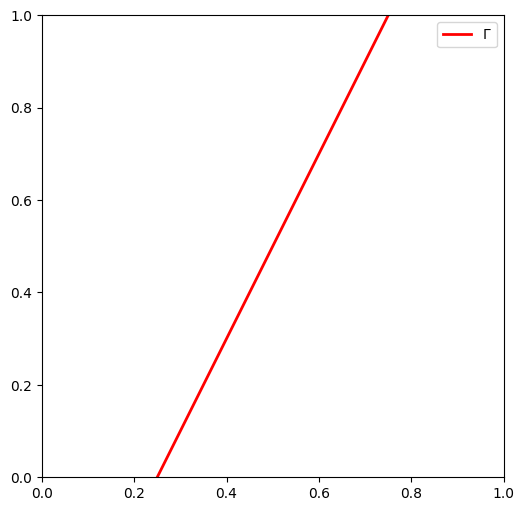

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# Plot fracture γ
ax.plot([x_start, x_end], [y_start-0.01, y_end+0.01],
        'r-', linewidth=2, label=r"$\Gamma$")

# Set exact domain bounds
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal', adjustable='box')  # force square axes

# Label and title
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_title(r"Domain $\Omega$ with fracture $\gamma$.")

# Disable autoscaling AFTER setting limits (prevents expansion)
ax.set_autoscale_on(False)

# Add legend last
ax.legend()

plt.show()

In [2]:
# APPROXIMATING EXACT SOLUTION and neumann bc
from dolfinx import mesh, fem
from dolfinx.mesh import locate_entities_boundary   # <-- NEW
import ufl
import numpy as np
# from dolfinx.cpp.mesh import compute_cell_sizes

# ---------------------------------------------------------------------
# 1. Mesh and interface tags (similar to Γ tagging in the workshop)
# ---------------------------------------------------------------------
from dolfinx.io import gmsh as gmshio
ref = N_ref-2
filename = f"Omega_ex1_{3}.msh"
Omega, cell_tags_Omega, facet_tags_Omega = gmshio.read_from_msh(
    filename, MPI.COMM_WORLD, 0, gdim=3
)[0:3]

coords = Omega.geometry.x
hx = np.min(np.diff(np.unique(np.sort(coords[:, 0]))))
hy = np.min(np.diff(np.unique(np.sort(coords[:, 1]))))
h = min(hx, hy)

# ================= Γ: line (1D embedded in 3D plane z=0) =================
gmsh.initialize()
h_g = h / 2
gmsh.model.add("Gamma")
p0 = gmsh.model.occ.addPoint(x_start, y_start, 0.01)
p1 = gmsh.model.occ.addPoint(x_end, y_end, 0.01)
line = gmsh.model.occ.addLine(p0, p1)
gmsh.model.occ.synchronize()

gmsh.model.mesh.setSize([(0, p0), (0, p1)], h_g)
pg_gamma = gmsh.model.addPhysicalGroup(1, [line])
gmsh.model.setPhysicalName(1, pg_gamma, "Gamma")
gmsh.model.mesh.generate(1)

Gamma, cell_tags_Gamma, facet_tags_Gamma = gmshio.model_to_mesh(
    gmsh.model, comm, rank, gdim=3
)[0:3]
gmsh.finalize()

# ================= function spaces (MIXED on Ω) =================
order = 2

Sigma_m = fem.functionspace(Omega, ("RT", order))        # flux u_m in H(div)
# V_m   = fem.functionspace(Omega, ("Discontinuous Lagrange", order - 1))
V_m     = fem.functionspace(Omega, ("Lagrange", order-1))  # bulk p_m
V_f     = fem.functionspace(Gamma, ("Lagrange", order-1))  # p_f on Γ
V_l     = fem.functionspace(Gamma, ("Lagrange", order-1))  # λ on Γ

W = ufl.MixedFunctionSpace(Sigma_m, V_m, V_f, V_l)

# ================= trial and test functions =================
v_m, q_m, psi, mu = ufl.TestFunctions(W)
u_m, p_m, p_f, lmbd = ufl.TrialFunctions(W)

from fenicsx_ii import Average, Circle
import basix.ufl

R = np.min([0.0001, h / 4])
q_degree = 16

restriction_trial = Circle(Gamma, R, degree=q_degree)
restriction_test  = Circle(Gamma, R, degree=q_degree)

q_el = basix.ufl.quadrature_element(Gamma.basix_cell(), value_shape=(), degree=q_degree)
Rs   = fem.functionspace(Gamma, q_el)

avg_pm  = Average(p_m, restriction_trial, Rs)
avg_qm  = Average(q_m, restriction_test,  Rs)

# Measures and normal
dx = ufl.Measure("dx", domain=Omega)
ds = ufl.Measure("dx", domain=Gamma)
ds_Omega = ufl.Measure("ds", domain=Omega)
n = ufl.FacetNormal(Omega)

# ================= bulk coefficients =================
k_values = np.array([[1.0, 0.0, 0.0],
                     [0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])
k_m     = fem.Constant(Omega, k_values)
k_m_inv = fem.Constant(Omega, np.linalg.pinv(k_values))  # (not used, but kept)

f_m = fem.Constant(Omega, 0.0)

# Bounding box and tolerances (numpy coords)
coords = Omega.geometry.x
x_np = coords[:, 0]
y_np = coords[:, 1]

xmin, xmax = x_np.min(), x_np.max()
ymin, ymax = y_np.min(), y_np.max()

tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# UFL coordinates for BC expressions
x_ufl = ufl.SpatialCoordinate(Omega)

g_left  = 1.0
g_right = 4.0

# Dirichlet data for p_m on left/right (weak in mixed form)
g_D = ufl.conditional(
    ufl.lt(abs(x_ufl[0] - xmin), tol), g_left,
    ufl.conditional(
        ufl.lt(abs(x_ufl[0] - xmax), tol), g_right,
        0.0
    )
)

# ================= bulk mixed weak form on Ω =================
a_m0 = (
    ufl.inner(u_m, v_m)                    # here we effectively use k^{-1}=I
    - p_m * ufl.div(k_m * v_m)             # - p div(k v)
    + q_m * ufl.div(u_m)                   # (div u) q
) * dx

# Coupling with λ via averaged bulk pressure test on Γ
a_m1 = - lmbd * avg_qm * ds

a_m = a_m0 + a_m1

# RHS: source + weak Dirichlet p on left/right (via g_D)
L_m = f_m * q_m * dx - g_D * ufl.dot(v_m, n) * ds_Omega

# ================= interface Γ and multiplier =================
f_f = fem.Constant(Gamma, 0.0)
k_f = fem.Constant(Gamma, 10.0)

a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
a_f1 = lmbd * psi * ds
a_f  = a_f0 + a_f1
L_f  = f_f * psi * ds

a_l0 =  avg_pm * mu * ds
a_l1 = -p_f   * mu * ds
a_l  = a_l0 + a_l1
L_l  = fem.Constant(Gamma, 0.0) * mu * ds

a_gamma = a_f + a_l
L_gamma = L_f + L_l

# ================= flux BC (u_m·n) on top and bottom like the demo =================
# Want:
#   top (y = ymax):    u·n = -1  -> u = (0, -1, 0)
#   bottom (y = ymin): u·n =  2  -> u = (0, -2, 0)

fdim = Omega.topology.dim - 1  # facets

def top_boundary(x):
    return np.isclose(x[1], ymax, atol=tol)

def bottom_boundary(x):
    return np.isclose(x[1], ymin, atol=tol)

top_facets = locate_entities_boundary(Omega, fdim, top_boundary)
bottom_facets = locate_entities_boundary(Omega, fdim, bottom_boundary)

# Functions for flux values on top and bottom in Q
u_top = fem.Function(Sigma_m)
u_bottom = fem.Function(Sigma_m)

def top_flux_expr(x):
    # shape (gdim, npts) = (3, npts)
    return np.vstack((
        np.zeros_like(x[0]),          # u_x = 0
        -np.ones_like(x[0]),          # u_y = -1
        np.zeros_like(x[0])           # u_z = 0
    ))

def bottom_flux_expr(x):
    return np.vstack((
        np.zeros_like(x[0]),          # u_x = 0
        -2.0 * np.ones_like(x[0]),    # u_y = -2
        np.zeros_like(x[0])           # u_z = 0
    ))

u_top.interpolate(top_flux_expr)
u_bottom.interpolate(bottom_flux_expr)

# Map facets to dofs in Sigma_sub via Q (same pattern as the 2D demo)
top_dofs = fem.locate_dofs_topological(Sigma_m, fdim, top_facets)
bottom_dofs = fem.locate_dofs_topological(Sigma_m, fdim, bottom_facets)
bc_top = fem.dirichletbc(u_top, top_dofs)
bc_bottom = fem.dirichletbc(u_bottom, bottom_dofs)

# ================= interface p_f BCs at the tips =================
tol_g = 1e-10 * np.max(np.ptp(Gamma.geometry.x, axis=0))

tip1_dofs = fem.locate_dofs_geometrical(
    V_f,
    lambda x: np.logical_and(
        np.isclose(x[0], x_start, atol=tol_g),
        np.isclose(x[1], y_start, atol=tol_g),
    ),
)
tip2_dofs = fem.locate_dofs_geometrical(
    V_f,
    lambda x: np.logical_and(
        np.isclose(x[0], x_end, atol=tol_g),
        np.isclose(x[1], y_end, atol=tol_g),
    ),
)

both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

pf_fun = fem.Function(V_f)
pf_fun.x.array[tip1_dofs] = 1.0
pf_fun.x.array[tip2_dofs] = 4.0

bc_pf = fem.dirichletbc(pf_fun, both_tips)

# === Strong Dirichlet BCs for bulk pressure p_m on left/right using V_m ===

def left_boundary_pm(x):
    return np.isclose(x[0], xmin, atol=tol)

def right_boundary_pm(x):
    return np.isclose(x[0], xmax, atol=tol)

# Locate dofs in the *bulk pressure* space V_m
pm_left_dofs = fem.locate_dofs_geometrical(V_m, left_boundary_pm)
pm_right_dofs = fem.locate_dofs_geometrical(V_m, right_boundary_pm)

# Create a function in V_m that will hold the boundary values
pm_fun = fem.Function(V_m)

# Assign Dirichlet values on the two sides
pm_fun.x.array[pm_left_dofs] = g_left
pm_fun.x.array[pm_right_dofs] = g_right

# Combine dofs and build a Dirichlet BC like you did for p_f
pm_dofs = np.unique(np.concatenate([pm_left_dofs, pm_right_dofs]))

bc_pm = fem.dirichletbc(pm_fun, pm_dofs)

# Collect BCs: flux on top/bottom + interface pressure at tips
bcs = [bc_top, bc_bottom, bc_pf]

# ================= assemble and solve =================
a = a_m + a_gamma
L = L_m + L_gamma

from fenicsx_ii import LinearProblem, assemble_scalar
petsc_options = {
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "ksp_error_if_not_converged": True,
}
problem = LinearProblem(
    a,
    L,
    petsc_options_prefix="coupled_poisson_mixed",
    petsc_options=petsc_options,
    bcs=bcs,
)

u_m, p_m, p_f, lmbd = problem.solve()
u_m.name = "u_m"
p_m.name = "p_m"
p_f.name = "p_f"
lmbd.name = "lmbd"

p_m_exact = p_m
p_f_exact = p_f
lmbd_exact = lmbd


Info    : Reading 'Omega_ex1_3.msh'...
Info    : 27 entities
Info    : 578 nodes
Info    : 256 elements
Info    : Done reading 'Omega_ex1_3.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000833191s, CPU 0.000942s)
Info    : 37 nodes 38 elements


In [3]:
from dolfinx.io import XDMFFile
import pathlib

outdir = pathlib.Path("result_case1_mixed_fem")
outdir.mkdir(exist_ok=True)

from dolfinx.io import XDMFFile

# ------------------------------
# 1) Save bulk field p_m on Ω
# ------------------------------
omega_file = outdir / "omega_finest_cg2.xdmf"
with XDMFFile(Omega.comm, str(omega_file), "w") as xdmf:
    xdmf.write_mesh(Omega)
    xdmf.write_function(p_m_exact)
# ---------------------------------------------------------------------------
# Postprocessing: project pressure to CG1 for visualization
# ---------------------------------------------------------------------------
# V_vis = fem.functionspace(Omega, ("Lagrange", 1))
# p_m_vis = fem.Function(V_vis)
# p_m_vis.name = "p_m"

# p_m_vis.interpolate(p_m)

# with XDMFFile(Omega.comm, "out_mixed_poisson/p_m_case4_mixed_fem.xdmf", "w") as file:
#     file.write_mesh(Omega)
#     file.write_function(p_m_vis)

# ------------------------------
# 2) Save interface fields p_f, λ on Γ
# ------------------------------
gamma_file = outdir / "gamma_finest_cg2.xdmf"
with XDMFFile(Gamma.comm, str(gamma_file), "w") as xdmf:
    xdmf.write_mesh(Gamma)
    xdmf.write_function(p_f_exact)
    xdmf.write_function(lmbd_exact)

Info    : Reading 'Omega_ex1_0.msh'...
Info    : 27 entities
Info    : 18 nodes
Info    : 4 elements
Info    : Done reading 'Omega_ex1_0.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 9.5661e-05s, CPU 0.000111s)
Info    : 6 nodes 7 elements


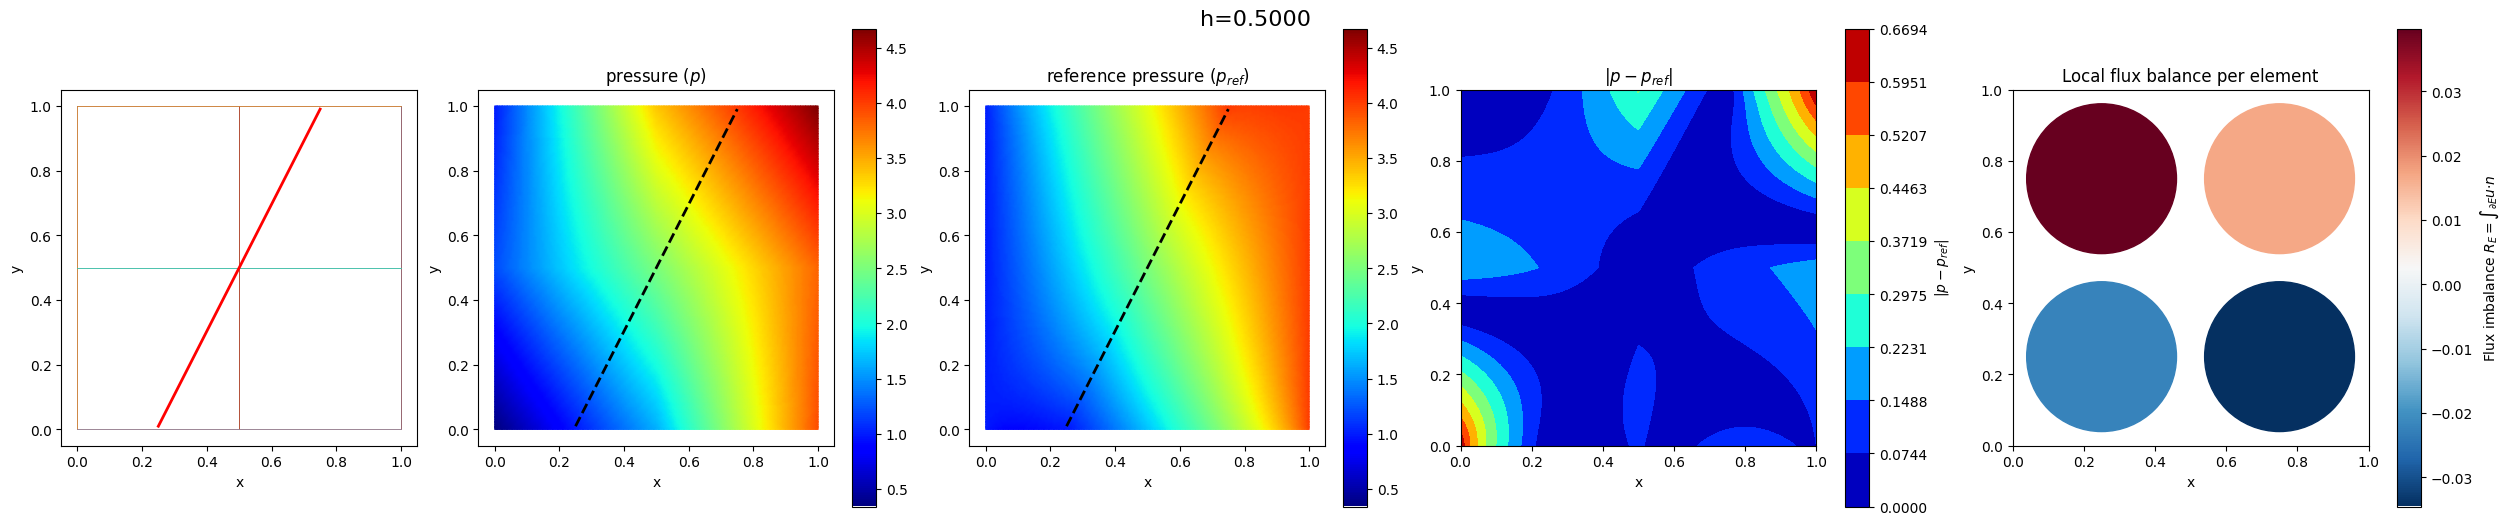

Info    : Reading 'Omega_ex1_1.msh'...
Info    : 27 entities
Info    : 50 nodes
Info    : 16 elements
Info    : Done reading 'Omega_ex1_1.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000172635s, CPU 0s)
Info    : 10 nodes 11 elements


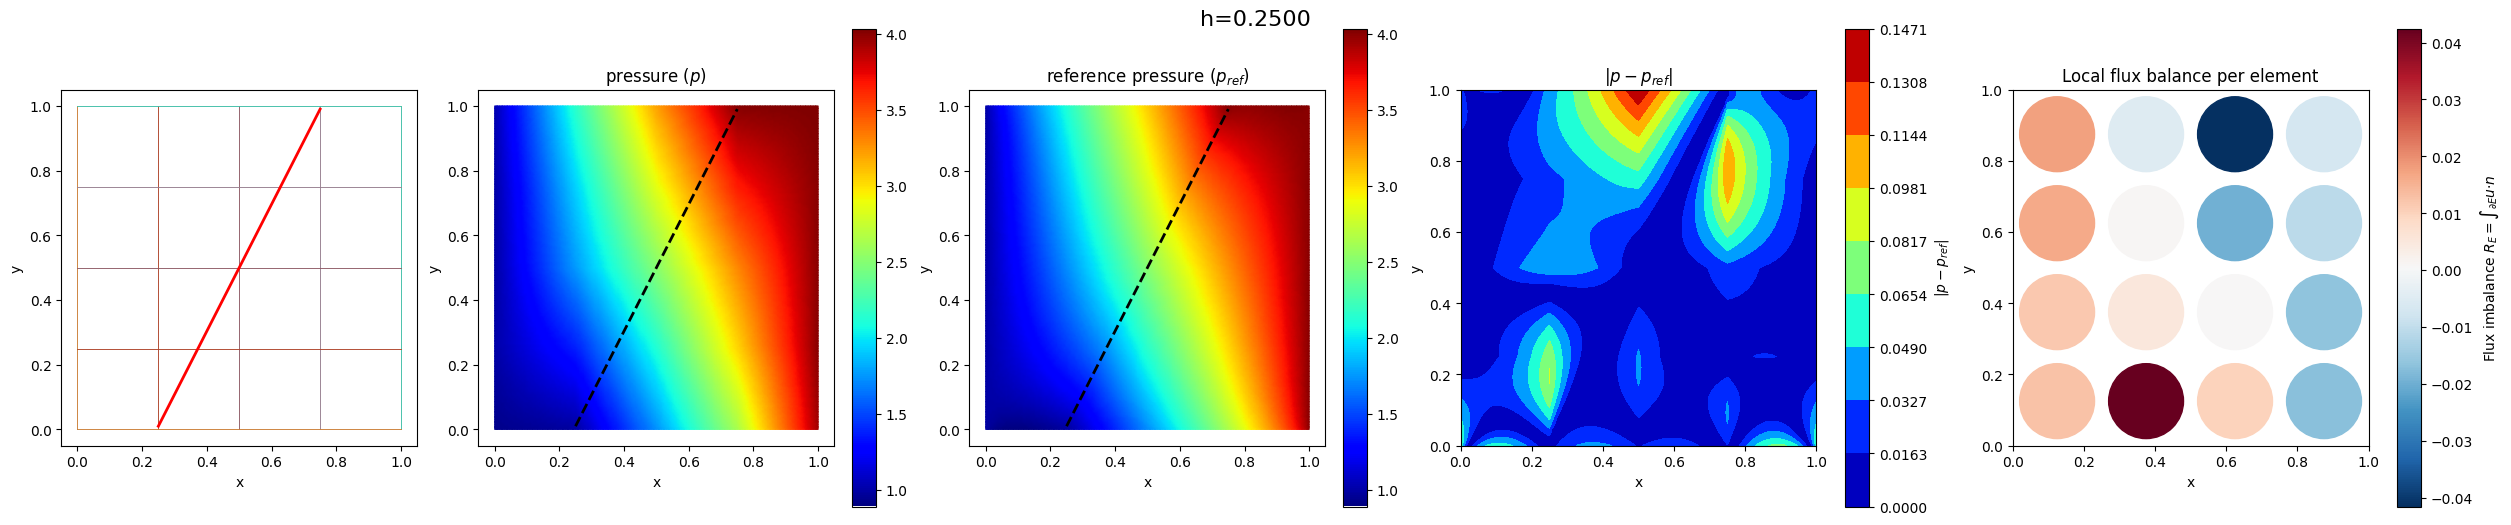

Info    : Reading 'Omega_ex1_2.msh'...
Info    : 27 entities
Info    : 162 nodes
Info    : 64 elements
Info    : Done reading 'Omega_ex1_2.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000123289s, CPU 0.00015s)
Info    : 19 nodes 20 elements


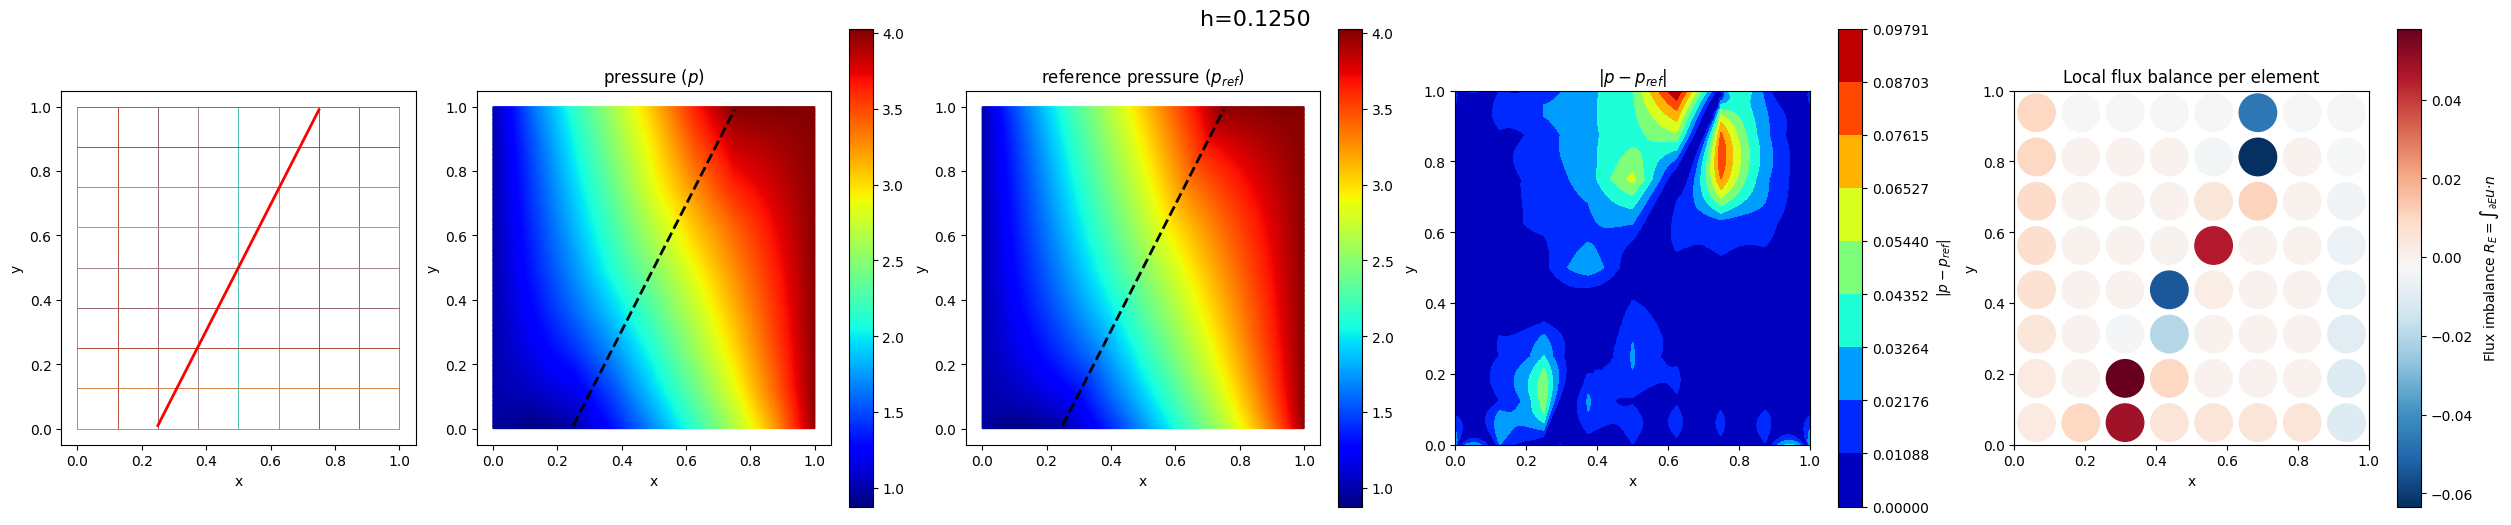

Info    : Reading 'Omega_ex1_3.msh'...
Info    : 27 entities
Info    : 578 nodes
Info    : 256 elements
Info    : Done reading 'Omega_ex1_3.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000159359s, CPU 0.000189s)
Info    : 37 nodes 38 elements


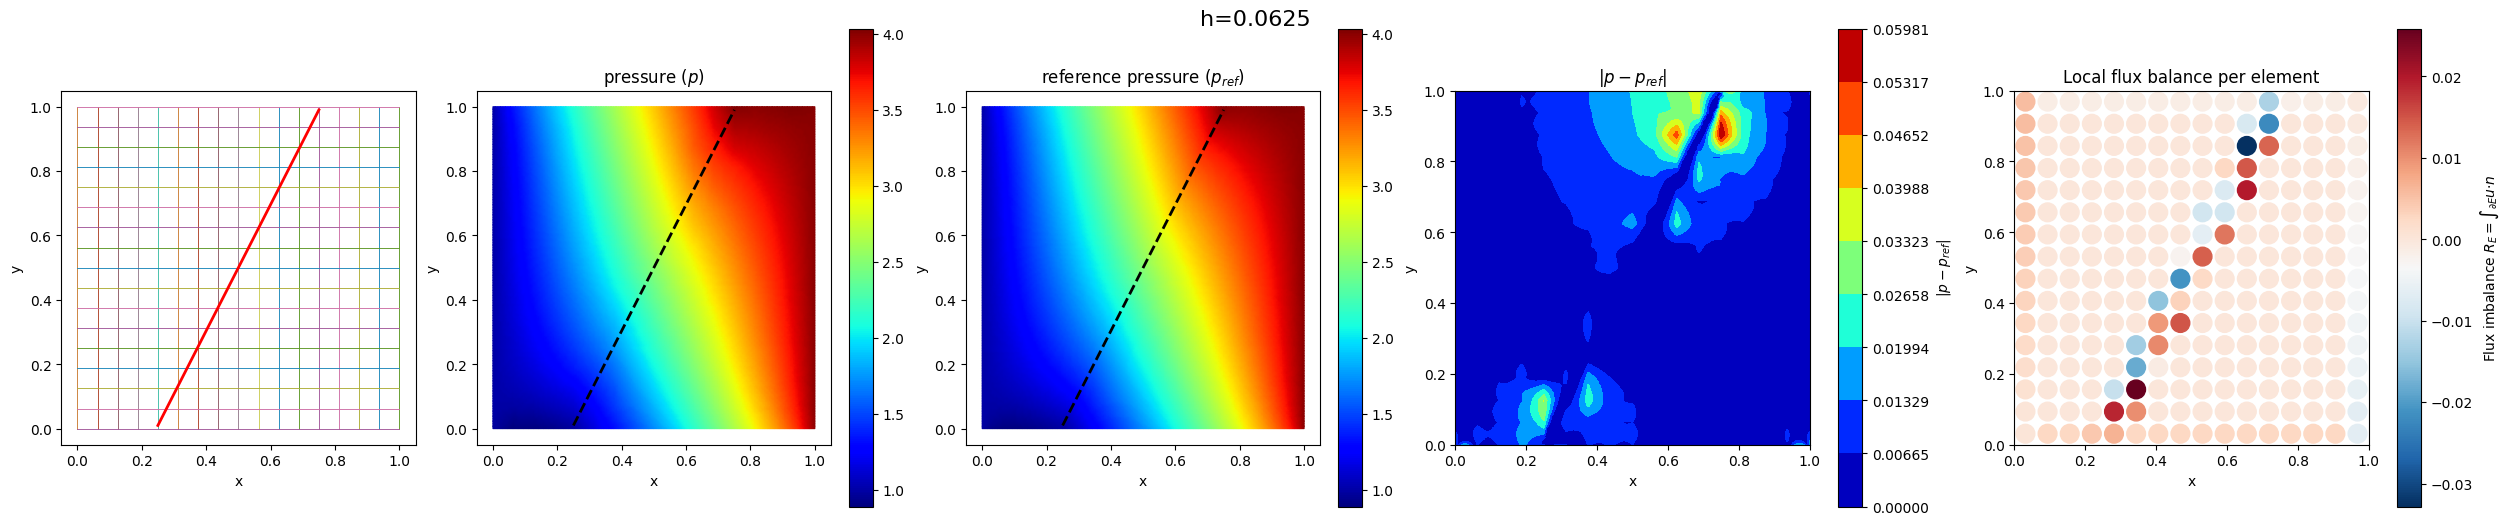

Info    : Reading 'Omega_ex1_4.msh'...
Info    : 27 entities
Info    : 2178 nodes
Info    : 1024 elements
Info    : Done reading 'Omega_ex1_4.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000113224s, CPU 0.000132s)
Info    : 72 nodes 73 elements


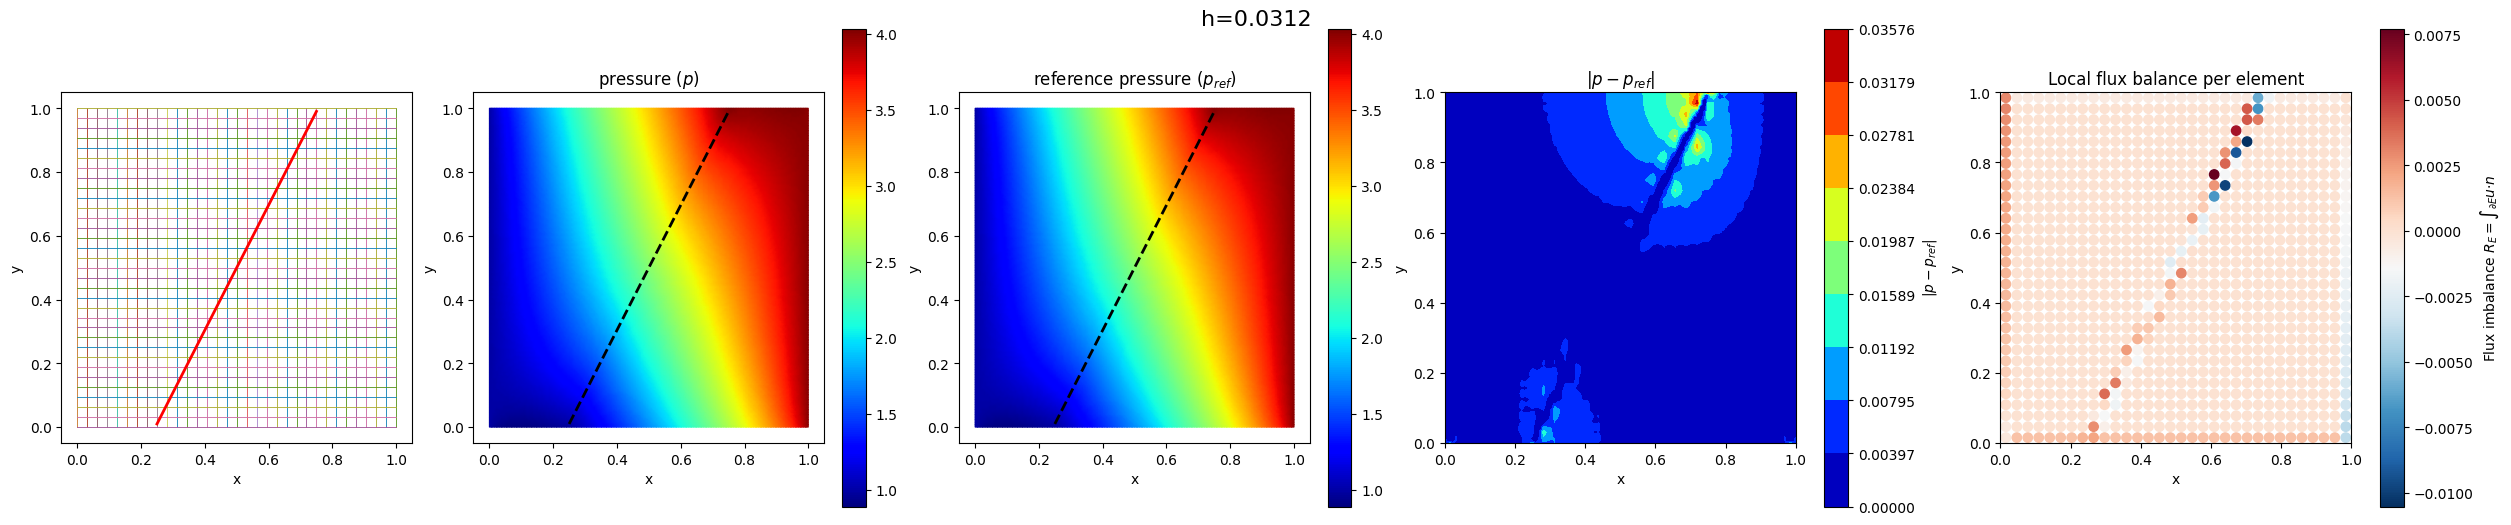

Info    : Reading 'Omega_ex1_5.msh'...
Info    : 27 entities
Info    : 8450 nodes
Info    : 4096 elements
Info    : Done reading 'Omega_ex1_5.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000300892s, CPU 0.000574s)
Info    : 142 nodes 143 elements


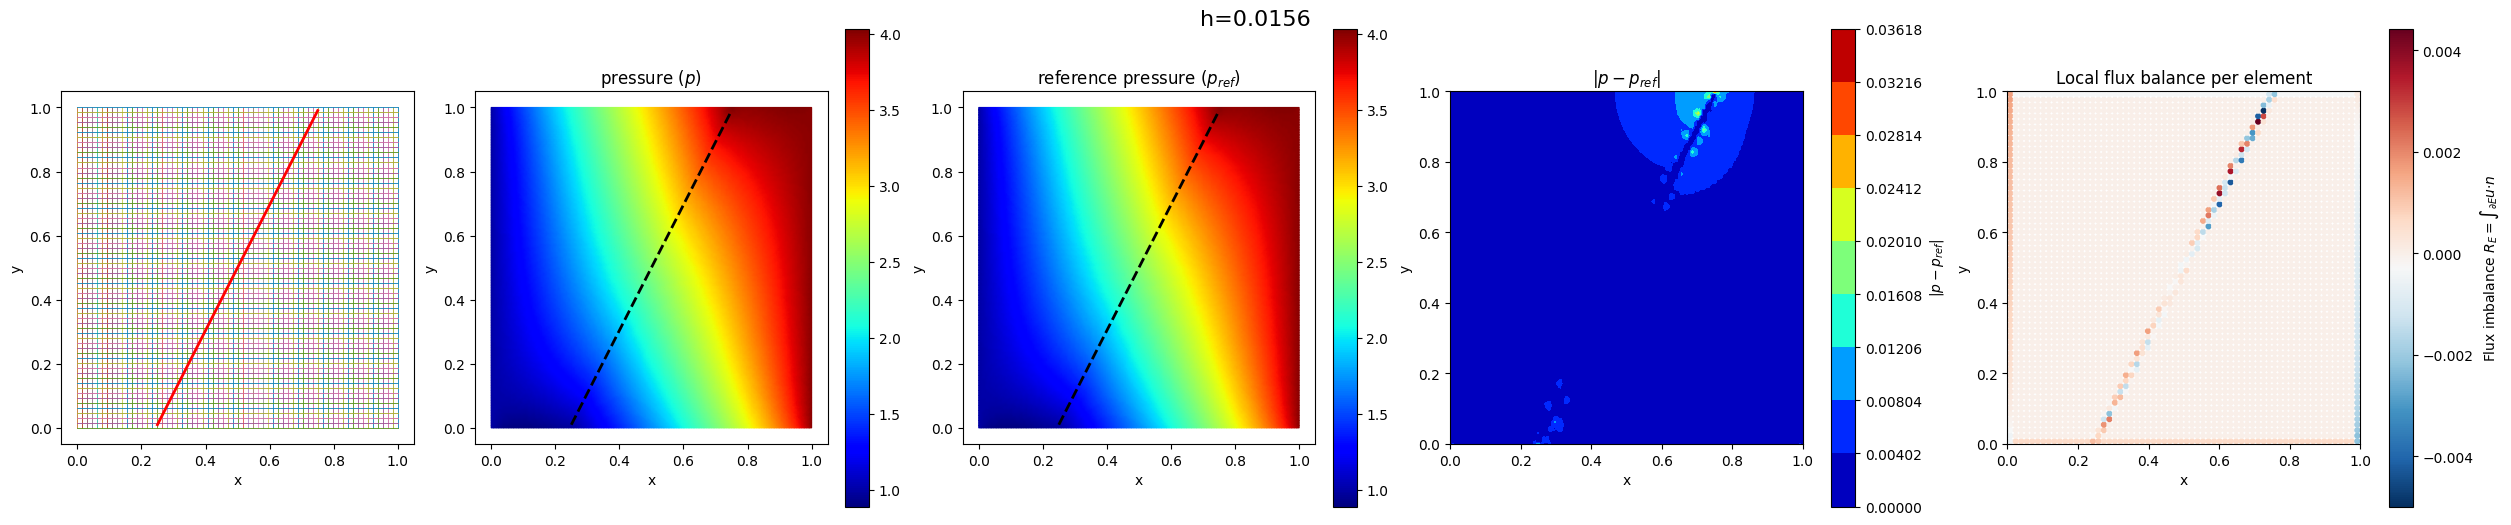

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


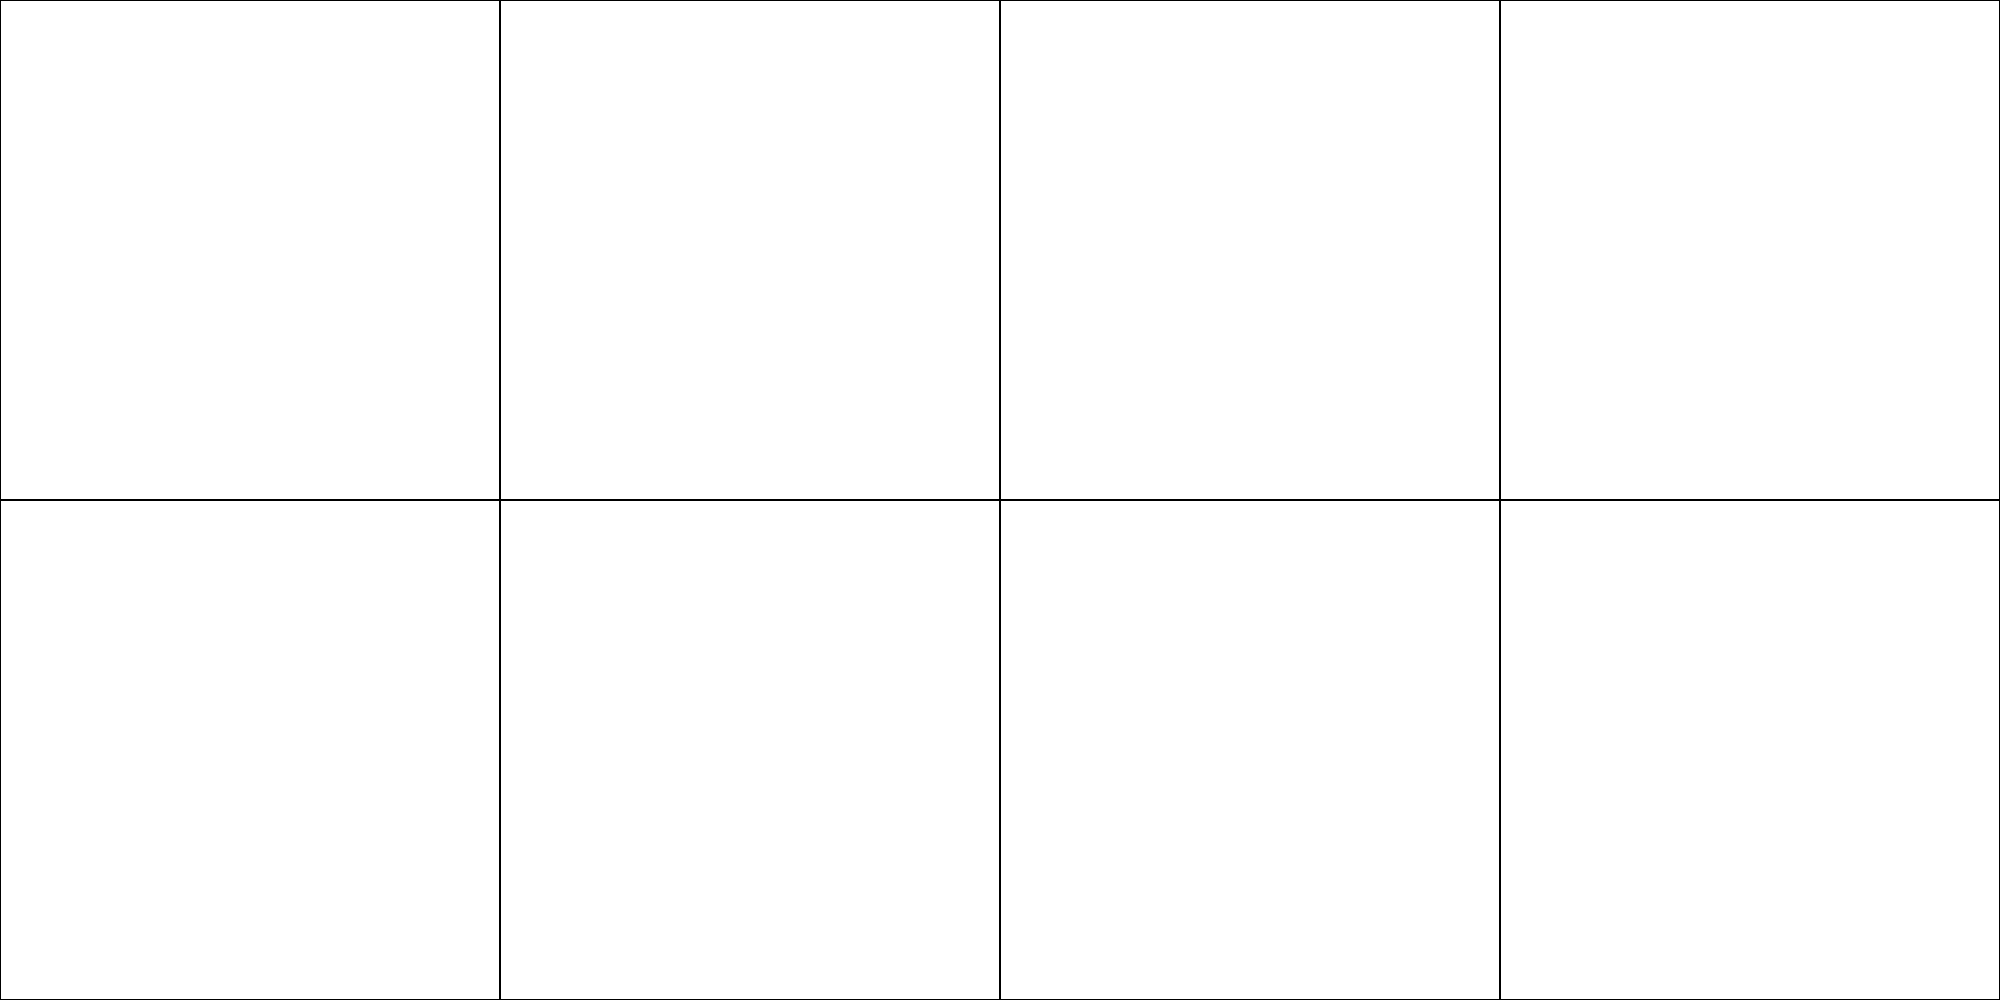

In [12]:
from dolfinx import geometry
def l2_h1_errors(p, p_exact, comm=MPI.COMM_WORLD):
    mesh_fine = p_exact.function_space.mesh
    mesh_coarse = p.function_space.mesh

    tdim = mesh_fine.topology.dim

    # --- Trees on the COARSE mesh (we will evaluate p on the coarse mesh) ---
    bbt_coarse = geometry.bb_tree(mesh_coarse, tdim)
    mid_tree_coarse = geometry.create_midpoint_tree(
        mesh_coarse, tdim,
        np.arange(mesh_coarse.topology.index_map(tdim).size_local, dtype=np.int32)
    )

    # --- Allocate target on the FINE space: p_coarse sampled at fine DoF points ---
    # p_exact is defined on the fine mesh, so reuse its function space
    p_coarse_on_exact = fem.Function(p_exact.function_space)

    def eval_p_coarse_on_points(x: np.ndarray) -> np.ndarray:
        """Return coarse solution p evaluated at points x on the FINE mesh."""
        gdim, N = x.shape
        if gdim == 2:
            X3 = np.column_stack([x.T, np.zeros(N, dtype=np.float64)])  # (N, 3)
        elif gdim == 3:
            X3 = x.T.copy()                                             # (N, 3)
        else:
            raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

        # 1) candidates on COARSE mesh
        cands = geometry.compute_collisions_points(bbt_coarse, X3)
        # 2) filter to true hits
        hits = geometry.compute_colliding_cells(mesh_coarse, cands, X3)

        # 3) pick one owning cell per point
        cells = np.full(N, -1, dtype=np.int32)
        for i in range(N):
            li = hits.links(i)
            if len(li) > 0:
                cells[i] = li[0]

        # Fallback: nearest coarse cell by midpoint
        missing = np.where(cells == -1)[0]
        if missing.size > 0:
            nearest = geometry.compute_closest_entity(
                bbt_coarse, mid_tree_coarse, mesh_coarse, X3[missing]
            )
            cells[missing] = nearest

        # 4) evaluate coarse solution p at those points/cells
        vals_1d = p.eval(X3, cells)  # (N,)
        return np.asarray(vals_1d, dtype=np.float64).reshape(1, N)  # scalar -> (1, N)
        # For vector-valued fields, adapt as in your comment.

    # Interpolate coarse solution into fine space
    p_coarse_on_exact.interpolate(eval_p_coarse_on_points)

    # --- Integrate on the FINE mesh/domain ---
    dx = ufl.dx(domain=mesh_fine)
    err = p_exact - p_coarse_on_exact

    # ||err||_L2^2
    L2_sq_local = fem.assemble_scalar(fem.form(ufl.inner(err, err) * dx))
    L2_sq = comm.allreduce(L2_sq_local, op=MPI.SUM)

    # |err|_H1^2 = ||∇err||_L2^2
    H1_semi_sq_local = fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(err), ufl.grad(err)) * dx))
    H1_semi_sq = comm.allreduce(H1_semi_sq_local, op=MPI.SUM)

    # Norms
    err_L2 = np.sqrt(L2_sq)
    err_H1_semi = np.sqrt(H1_semi_sq)
    err_H1_full = np.sqrt(L2_sq + H1_semi_sq)

    # --- relative errors ---
    # ||p_exact||_L2^2
    L2_exact_sq_local = fem.assemble_scalar(fem.form(ufl.inner(p_coarse_on_exact, p_coarse_on_exact) * dx))
    L2_exact_sq = comm.allreduce(L2_exact_sq_local, op=MPI.SUM)

    # |p_exact|_H1^2
    H1_semi_exact_sq_local = fem.assemble_scalar(
        fem.form(ufl.inner(ufl.grad(p_coarse_on_exact), ufl.grad(p_coarse_on_exact)) * dx)
    )
    H1_semi_exact_sq = comm.allreduce(H1_semi_exact_sq_local, op=MPI.SUM)

    # Norms of exact
    exact_L2 = np.sqrt(L2_exact_sq)
    exact_H1_semi = np.sqrt(H1_semi_exact_sq)
    exact_H1_full = np.sqrt(L2_exact_sq + H1_semi_exact_sq)

    # Relative errors with zero-denominator guard
    rel_L2 = err_L2 / exact_L2 if exact_L2 > 0 else (0.0 if err_L2 == 0 else np.inf)
    rel_H1_semi = err_H1_semi / exact_H1_semi if exact_H1_semi > 0 else (0.0 if err_H1_semi == 0 else np.inf)
    rel_H1_full = err_H1_full / exact_H1_full if exact_H1_full > 0 else (0.0 if err_H1_full == 0 else np.inf)

    return {
        "err_L2": err_L2,
        "err_H1_semi": err_H1_semi,
        "err_H1_full": err_H1_full,
        "rel_L2": rel_L2,
        "rel_H1_semi": rel_H1_semi,   # <-- often what people plot as “H1 error”
        "rel_H1_full": rel_H1_full
    }
    # return err_L2, err_H1_full

from dolfinx.io import XDMFFile
import pathlib

outdir = pathlib.Path("result_nonconforming_case4_mixedfem")
outdir.mkdir(exist_ok=True)
for ref in range(N_ref-2):
    filename = f"Omega_ex1_{ref}.msh"
    Omega, cell_tags_Omega, facet_tags_Omega = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=3)[0:3]
    tdim = Omega.topology.dim  # 2
    # fdim = 1             # 1
    # Compute cell diameters (length of the longest edge in each cell)
    # all_h = compute_cell_sizes(Omega, "max")

    # For example, get average or min/max
    # h = Omega.comm.allreduce(np.median(h.array), op=MPI.SUM) / Omega.comm.size

    coords = Omega.geometry.x
    hx = np.min(np.diff(np.unique(np.sort(coords[:,0]))))
    hy = np.min(np.diff(np.unique(np.sort(coords[:,1]))))
    h = min(hx, hy)
    # Clear gmsh model before building Γ
    # gmsh.clear()

    # ================= Γ: line (1D embedded in 3D plane z=0) =================
    gmsh.initialize()
    h_g = h/2
    gmsh.model.add("Gamma")
    p0 = gmsh.model.occ.addPoint(x_start, y_start, 0.01)
    p1 = gmsh.model.occ.addPoint(x_end, y_end, 0.01)
    line = gmsh.model.occ.addLine(p0, p1)
    gmsh.model.occ.synchronize()

    gmsh.model.mesh.setSize([(0, p0), (0, p1)], h_g)
    pg_gamma = gmsh.model.addPhysicalGroup(1, [line])
    gmsh.model.setPhysicalName(1, pg_gamma, "Gamma")
    gmsh.model.mesh.generate(1)

    # Import Gamma mesh, embed in 3D (gdim=3)
    Gamma, cell_tags_Gamma, facet_tags_Gamma = gmshio.model_to_mesh(gmsh.model, comm, rank, gdim=3)[0:3]

    gmsh.finalize()

    # ================= function spaces (MIXED on Ω) =================
    order = 2

    Sigma_m = fem.functionspace(Omega, ("RT", order))        # flux u_m in H(div)
    # V_m   = fem.functionspace(Omega, ("Discontinuous Lagrange", order - 1))
    V_m     = fem.functionspace(Omega, ("Lagrange", order-1))  # bulk p_m
    V_f     = fem.functionspace(Gamma, ("Lagrange", order-1))  # p_f on Γ
    V_l     = fem.functionspace(Gamma, ("Lagrange", order-1))  # λ on Γ

    W = ufl.MixedFunctionSpace(Sigma_m, V_m, V_f, V_l)

    # ================= trial and test functions =================
    v_m, q_m, psi, mu = ufl.TestFunctions(W)
    u_m, p_m, p_f, lmbd = ufl.TrialFunctions(W)

    from fenicsx_ii import Average, Circle
    import basix.ufl

    R = np.min([0.01, h / 4])
    q_degree = 16

    restriction_trial = Circle(Gamma, R, degree=q_degree)
    restriction_test  = Circle(Gamma, R, degree=q_degree)

    q_el = basix.ufl.quadrature_element(Gamma.basix_cell(), value_shape=(), degree=q_degree)
    Rs   = fem.functionspace(Gamma, q_el)

    avg_pm  = Average(p_m, restriction_trial, Rs)
    avg_qm  = Average(q_m, restriction_test,  Rs)

    # Measures and normal
    dx = ufl.Measure("dx", domain=Omega)
    ds = ufl.Measure("dx", domain=Gamma)
    ds_Omega = ufl.Measure("ds", domain=Omega)
    n = ufl.FacetNormal(Omega)

    # ================= bulk coefficients =================
    k_values = np.array([[1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0]])
    k_m     = fem.Constant(Omega, k_values)
    k_m_inv = fem.Constant(Omega, np.linalg.pinv(k_values))  # (not used, but kept)

    f_m = fem.Constant(Omega, 0.0)

    # Bounding box and tolerances (numpy coords)
    coords = Omega.geometry.x
    x_np = coords[:, 0]
    y_np = coords[:, 1]

    xmin, xmax = x_np.min(), x_np.max()
    ymin, ymax = y_np.min(), y_np.max()

    tol = 1e-10 * max(xmax - xmin, ymax - ymin)

    # UFL coordinates for BC expressions
    x_ufl = ufl.SpatialCoordinate(Omega)

    g_left  = 1.0
    g_right = 4.0

    # Dirichlet data for p_m on left/right (weak in mixed form)
    g_D = ufl.conditional(
        ufl.lt(abs(x_ufl[0] - xmin), tol), g_left,
        ufl.conditional(
            ufl.lt(abs(x_ufl[0] - xmax), tol), g_right,
            0.0
        )
    )

    # ================= bulk mixed weak form on Ω =================
    a_m0 = (
        ufl.inner(u_m, v_m)                    # here we effectively use k^{-1}=I
        - p_m * ufl.div(k_m * v_m)             # - p div(k v)
        + q_m * ufl.div(u_m)                   # (div u) q
    ) * dx

    # Coupling with λ via averaged bulk pressure test on Γ
    a_m1 = - lmbd * avg_qm * ds

    a_m = a_m0 + a_m1

    # RHS: source + weak Dirichlet p on left/right (via g_D)
    L_m = f_m * q_m * dx - g_D * ufl.dot(v_m, n) * ds_Omega

    # ================= interface Γ and multiplier =================
    f_f = fem.Constant(Gamma, 0.0)
    k_f = fem.Constant(Gamma, 10.0)

    a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
    a_f1 = lmbd * psi * ds
    a_f  = a_f0 + a_f1
    L_f  = f_f * psi * ds

    a_l0 =  avg_pm * mu * ds
    a_l1 = -p_f   * mu * ds
    a_l  = a_l0 + a_l1
    L_l  = fem.Constant(Gamma, 0.0) * mu * ds

    a_gamma = a_f + a_l
    L_gamma = L_f + L_l

    # ================= flux BC (u_m·n) on top and bottom like the demo =================
    # Want:
    #   top (y = ymax):    u·n = -1  -> u = (0, -1, 0)
    #   bottom (y = ymin): u·n =  2  -> u = (0, -2, 0)

    fdim = Omega.topology.dim - 1  # facets

    def top_boundary(x):
        return np.isclose(x[1], ymax, atol=tol)

    def bottom_boundary(x):
        return np.isclose(x[1], ymin, atol=tol)

    top_facets = locate_entities_boundary(Omega, fdim, top_boundary)
    bottom_facets = locate_entities_boundary(Omega, fdim, bottom_boundary)

    # Functions for flux values on top and bottom in Q
    u_top = fem.Function(Sigma_m)
    u_bottom = fem.Function(Sigma_m)

    def top_flux_expr(x):
        # shape (gdim, npts) = (3, npts)
        return np.vstack((
            np.zeros_like(x[0]),          # u_x = 0
            -np.ones_like(x[0]),          # u_y = -1
            np.zeros_like(x[0])           # u_z = 0
        ))

    def bottom_flux_expr(x):
        return np.vstack((
            np.zeros_like(x[0]),          # u_x = 0
            -2.0 * np.ones_like(x[0]),    # u_y = -2
            np.zeros_like(x[0])           # u_z = 0
        ))

    u_top.interpolate(top_flux_expr)
    u_bottom.interpolate(bottom_flux_expr)

    # Map facets to dofs in Sigma_sub via Q (same pattern as the 2D demo)
    top_dofs = fem.locate_dofs_topological(Sigma_m, fdim, top_facets)
    bottom_dofs = fem.locate_dofs_topological(Sigma_m, fdim, bottom_facets)
    bc_top = fem.dirichletbc(u_top, top_dofs)
    bc_bottom = fem.dirichletbc(u_bottom, bottom_dofs)

    # ================= interface p_f BCs at the tips =================
    tol_g = 1e-10 * np.max(np.ptp(Gamma.geometry.x, axis=0))

    tip1_dofs = fem.locate_dofs_geometrical(
        V_f,
        lambda x: np.logical_and(
            np.isclose(x[0], x_start, atol=tol_g),
            np.isclose(x[1], y_start, atol=tol_g),
        ),
    )
    tip2_dofs = fem.locate_dofs_geometrical(
        V_f,
        lambda x: np.logical_and(
            np.isclose(x[0], x_end, atol=tol_g),
            np.isclose(x[1], y_end, atol=tol_g),
        ),
    )

    both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

    pf_fun = fem.Function(V_f)
    pf_fun.x.array[tip1_dofs] = 1.0
    pf_fun.x.array[tip2_dofs] = 4.0

    bc_pf = fem.dirichletbc(pf_fun, both_tips)

    # Collect BCs: flux on top/bottom + interface pressure at tips
    bcs = [bc_top, bc_bottom, bc_pf]

    # ================= assemble and solve =================
    a = a_m + a_gamma
    L = L_m + L_gamma

    from fenicsx_ii import LinearProblem, assemble_scalar
    petsc_options = {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    }
    problem = LinearProblem(
        a,
        L,
        petsc_options_prefix="coupled_poisson_mixed",
        petsc_options=petsc_options,
        bcs=bcs,
    )

    u_m, p_m, p_f, lmbd = problem.solve()
    u_m.name = "u_m"
    p_m.name = "p_m"
    p_f.name = "p_f"
    lmbd.name = "lmbd"

    from dolfinx.io import XDMFFile

    # ------------------------------
    # 1) Save bulk field p_m on Ω
    # ------------------------------
    omega_file = outdir / f"omega_ref{ref}.xdmf"
    with XDMFFile(Omega.comm, str(omega_file), "w") as xdmf:
        xdmf.write_mesh(Omega)
        xdmf.write_function(p_m)

    # ------------------------------
    # 2) Save interface fields p_f, λ on Γ
    # ------------------------------
    gamma_file = outdir / f"gamma_ref{ref}.xdmf"
    with XDMFFile(Gamma.comm, str(gamma_file), "w") as xdmf:
        xdmf.write_mesh(Gamma)
        xdmf.write_function(p_f)
        xdmf.write_function(lmbd)

    err_dict = l2_h1_errors(p_m, p_m_exact)
    err_dict_pf = l2_h1_errors(p_f, p_f_exact)
    err_dict_lmbd = l2_h1_errors(lmbd, lmbd_exact)
    err_L2_fem, err_H1_fem, rel_L2_fem, rel_H1_full_fem = err_dict["err_L2"], err_dict["err_H1_semi"], err_dict["rel_L2"], err_dict["rel_H1_semi"]
    err_L2_fem_pf, err_H1_fem_pf, rel_L2_fem_pf, rel_H1_full_fem_pf = err_dict_pf["err_L2"], err_dict_pf["err_H1_semi"], err_dict_pf["rel_L2"], err_dict_pf["rel_H1_semi"]
    err_L2_fem_lmbd, err_H1_fem_lmbd, rel_L2_fem_lmbd, rel_H1_full_fem_lmbd = err_dict_lmbd["err_L2"], err_dict_lmbd["err_H1_semi"], err_dict_lmbd["rel_L2"], err_dict_lmbd["rel_H1_semi"]

    thickness = 0.02          # same value you extruded with
    z_mid = 0 / 2.0   # center of the slab
    # --- Mesh & spaces ---
    mesh_c = p_m.function_space.mesh           # COARSE mesh
    mesh_f = p_m_exact.function_space.mesh     # FINE mesh
    tdim_c = mesh_c.topology.dim
    tdim_f = mesh_f.topology.dim
    gdim = mesh_f.geometry.dim
    mesh_f.topology.create_connectivity(tdim_f, 0)  # cell -> vertex (you likely already had this)
    mesh_f.topology.create_connectivity(0, tdim_f)  # vertex -> cell (REQUIRED for locate_dofs_topological)

    # --- 0) get fine dof coordinates as evaluation points ---
    V_f = p_m_exact.function_space
    X_f = V_f.tabulate_dof_coordinates().reshape(-1, gdim)   # (Nf, gdim)
    Nf = X_f.shape[0]

    if gdim == 2:
        X3_f = np.column_stack([X_f, np.zeros(Nf, dtype=np.float64)])  # (Nf, 3)
    elif gdim == 3:
        X3_f = X_f.copy()                                              # (Nf, 3)
    else:
        raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

    # --- 1) build tree on the COARSE mesh (where p_m lives) ---
    bbt_c = geometry.bb_tree(mesh_c, tdim_c)
    cands = geometry.compute_collisions_points(bbt_c, X3_f)
    hits = geometry.compute_colliding_cells(mesh_c, cands, X3_f)

    cells = np.full(Nf, -1, dtype=np.int32)
    for i in range(Nf):
        li = hits.links(i)
        if len(li) > 0:
            cells[i] = li[0]

    # robust fallback for any misses (-1), e.g. points on boundaries/tiny roundoff
    missing = np.where(cells == -1)[0]
    if missing.size:
        mid_tree_c = geometry.create_midpoint_tree(
            mesh_c, tdim_c,
            np.arange(mesh_c.topology.index_map(tdim_c).size_local, dtype=np.int32)
        )
        nearest = geometry.compute_closest_entity(bbt_c, mid_tree_c, mesh_c, X3_f[missing])
        cells[missing] = nearest

    # --- 2) evaluate p_m (COARSE solution) at those FINE-space coordinates ---
    p_coarse_on_finepts = p_m.eval(X3_f, cells).ravel()

    # --- 3) grab the "exact" values at their own fine dofs ---
    # (for standard Lagrange/nodal spaces, coefficient = nodal value)
    p_exact_vals = p_m_exact.x.array.copy().ravel()

    # 4) build plotting arrays (no error norms here)
    x = X_f[:, 0].ravel()
    y = X_f[:, 1].ravel()
    diff_abs = np.abs(p_exact_vals - p_coarse_on_finepts)

    # triangulation in the (x, y) plane
    import matplotlib.tri as mtri
    import matplotlib.pyplot as plt
    
    tri = mtri.Triangulation(x, y)

    V_c = p_m.function_space
    # mesh_c = V_c.mesh
    gdim_c = mesh_c.geometry.dim

    # --- 1) Get coordinates ---
    X_c = V_c.tabulate_dof_coordinates().reshape(-1, gdim_c)

    # --- 2) Reduce to 2D by taking a slice if needed ---
    if gdim_c == 2:
        X2 = X_c[:, :2]
    elif gdim_c == 3:
        z = X_c[:, 2]
        z0 = z.min()
        mask = np.isclose(z, z0, atol=1e-10)
        X2 = X_c[mask, :2]      # x, y only
    else:
        raise ValueError("Unsupported geometric dimension")

    # --- 3) Extract unique grid lines ---
    xc = np.unique(X2[:, 0])   # x grid lines
    yc = np.unique(X2[:, 1])   # y grid lines

    # common color range taken from both fields
    vmin = float(min(np.nanmin(p_exact_vals), np.nanmin(p_coarse_on_finepts)))
    vmax = float(max(np.nanmax(p_exact_vals), np.nanmax(p_coarse_on_finepts)))

    # --- PyVista rendering of p_m on its mesh (as you had) ---
    # topo2, ctype2, geom2 = plot.vtk_mesh(p_m.function_space)
    # grid_2d = pv.UnstructuredGrid(topo2, ctype2, geom2)
    # grid_2d.point_data["p_m"] = p_m.x.array.real

    # optional: a segment to overlay (keep your existing endpoints)
    # x_start, x_end, y_start, y_end must exist if you want the line shown
    have_line = all(name in globals() for name in ["x_start","x_end","y_start","y_end"])

    fig, axes = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)
    fig.suptitle(f"h={h:.4f}", fontsize=16, y=1.02)  # keep your h variable

    # axes[0].triplot(tri_c, linewidth=0.5)
    # --- 4) Plot the grid (NO meshgrid used) ---
    # x grid lines (vertical)
    fig3, ax3 = plt.subplots(figsize=(5, 5))
    for xv in xc:
        axes[0].plot([xv, xv], [y.min(), y.max()], linewidth=0.5)
        ax3.plot([xv, xv], [y.min(), y.max()],color='#1f77b4', linewidth=0.5)

    # y grid lines (horizontal)
    for yv in yc:
        axes[0].plot([x.min(), x.max()], [yv, yv], linewidth=0.5)
        ax3.plot([x.min(), x.max()], [yv, yv],color='#1f77b4', linewidth=0.5)
    axes[0].plot([x_start, x_end], [y_start, y_end],
        'r-', linewidth=2, label=r"$\Gamma$")
    ax3.plot([x_start, x_end], [y_start, y_end],
    'r-', linewidth=2, label=r"$\Gamma$")
    axes[0].set_aspect('equal')
    ax3.set_aspect('equal')
    
    mesh_plot = ax3
    # ax2.set_title('|p_m - p_m_ref|')
    ax3.set_aspect('equal')

    # fig3.colorbar(cont2, ax=ax2)
    fig3.savefig(f"nonconforming_mesh{ref}.png", dpi=300, bbox_inches='tight')
    plt.close(fig3)

    # Panel 1: p_m sampled at exact dofs
    im0 = axes[1].tripcolor(tri, p_coarse_on_finepts, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    if have_line:
        axes[1].plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
    axes[1].set_title('pressure ($p$)')
    axes[1].set_aspect('equal')
    fig.colorbar(im0, ax=axes[1])

    # Panel 2: p_m_exact values at its dofs
    im1 = axes[2].tripcolor(tri, p_exact_vals, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    if have_line:
        axes[2].plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
    axes[2].set_title('reference pressure ($p_{ref}$)')
    axes[2].set_aspect('equal')
    fig.colorbar(im1, ax=axes[2])

    # Panel 3: absolute difference contours
    levels = np.linspace(diff_abs.min(), np.percentile(diff_abs, 100), 10)
    cont = axes[3].tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    axes[3].set_title('$|p - p_{ref}|$')
    axes[3].set_aspect('equal')
    fig.colorbar(cont, ax=axes[3], label='$|p - p_{ref}|$')

    fig2, ax2 = plt.subplots(figsize=(5, 5))

    cont2 = ax2.tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    ax2.set_aspect('equal')

    fig2.colorbar(cont2, ax=ax2)
    fig2.savefig(f"error_nonconform_{ref}.png", dpi=300, bbox_inches='tight')
    plt.close(fig2)


    n = ufl.FacetNormal(Omega)
    u = u_m

    # DG0 space for element-wise residual
    # create DG0 space to store results
    W = fem.functionspace(Omega, ("DG", 0))
    w = ufl.TestFunction(W)

    # Average of the DG0 test function on Γ
    avg_w = Average(w, restriction_test, Rs)  # Π_R(w) on Γ
    # if you want ∫∂K u·n − ∫ Γ λ = 0
    # Measures: bulk facets and fracture cells
    dS_omega = ufl.Measure("dS", domain=Omega)   # interior facets of omega
    # dS_mm = dS_omega(0)
    ds_omega = ufl.Measure("ds", domain=Omega)   # boundary facets of omega
    R_form = (
        ufl.jump(u, n)*ufl.avg(w)*dS_omega
        + ufl.dot(u, n)*w*ds_omega
        - lmbd * avg_w * ds
    )
    # R_vec = fem.petsc.assemble_vector(fem.form(R_form))
    from fenicsx_ii import assemble_vector
    R_vec = assemble_vector(R_form)

    R = fem.Function(W)
    R.x.array[:] = R_vec.array
    R.x.scatter_forward()

    # Compute cell centroids
    mesh = Omega
    tdim = mesh.topology.dim
    mesh.topology.create_connectivity(tdim, 0)
    cell_to_vertices = mesh.topology.connectivity(tdim, 0)
    x = mesh.geometry.x

    centroids = np.array([
        x[cell_to_vertices.links(c)].mean(axis=0)
        for c in range(mesh.topology.index_map(tdim).size_local)
    ])

    # Get local residual values (per cell)
    R_local = R.x.array

    dx_points = axes[4].transData.transform((1,0))[0] - axes[4].transData.transform((0,0))[0]
    dy_points = axes[4].transData.transform((0,1))[1] - axes[4].transData.transform((0,0))[1]
    r_points = h/2 * 0.6 * (dx_points + dy_points)   # average for roughly equal scaling

    # Marker size in points²
    s_val = r_points**2

    sc = axes[4].scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=s_val, cmap="RdBu_r")
    axes[4].set_aspect('equal')
    fig.colorbar(sc, ax=axes[4], label="Flux imbalance $R_E = ∫_{∂E} u·n$")
    # plt.colorbar(sc, )
    axes[4].set_title("Local flux balance per element")
    axes[4].set_xlim(0, 1)
    axes[4].set_ylim(0, 1)

    fig4, ax4 = plt.subplots(figsize=(5, 5))

    cont4 = ax4.scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=s_val, cmap="RdBu_r")
    ax4.set_aspect('equal')

    fig4.colorbar(cont4, ax=ax4)
    fig4.savefig(f"Flux_imbalance_{ref}.png", dpi=300, bbox_inches='tight')
    plt.close(fig4)
    
    # plt.axis("equal")
    # plt.xlabel("x"); plt.ylabel("y")
    # plt.title("Local flux balance per element")

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    plt.show()
    
    if MPI.COMM_WORLD.rank == 0:
        h_list.append(float(h))
        # L2_list.append(float(L2_err))
        # rL2_list.append(float(rel_L2))
        L2_fem_list.append(float(err_L2_fem))
        rL2s_fem_list.append(float(rel_L2_fem))
        H1s_list.append(float(err_H1_fem))
        rH1s_list.append(float(rel_H1_full_fem))

        L2_fem_list_pf.append(float(err_L2_fem_pf))
        rL2s_fem_list_pf.append(float(rel_L2_fem_pf))
        H1s_list_pf.append(float(err_H1_fem_pf))
        rH1s_list_pf.append(float(rel_H1_full_fem_pf))

        L2_fem_list_lmbd.append(float(err_L2_fem_lmbd))
        rL2s_fem_list_lmbd.append(float(rel_L2_fem_lmbd))
        H1s_list_lmbd.append(float(err_H1_fem_lmbd))
        rH1s_list_lmbd.append(float(rel_H1_full_fem_lmbd))

    # if ref < 8:
    #     # Panel 1: MRST (cells)
    #     ip = int(ref/4)
    #     jp = ref % 4
    #     plotter.subplot(ip, jp)
    #     plotter.add_mesh(
    #         grid_2d, scalars="p_m", cmap="jet", show_edges=True, lighting=True,
    #         clim=[1, 4],
    #         scalar_bar_args={"title": "FEM p_m", "vertical": True, "width": 0.05, "height": 0.7}
    #     )
    #     plotter.show_bounds(); plotter.view_xy()
    #     plotter.link_views()
plotter.show()
    

In [7]:
from math import log
if MPI.COMM_WORLD.rank == 0 and len(h_list) > 0:
    # rates: p_i = log(e_{i-1}/e_i) / log(h_{i-1}/h_i)
    def _roc(errs, hs):
        out = [None]
        for i in range(1, len(errs)):
            e0, e1 = errs[i-1], errs[i]
            h0, h1 = hs[i-1], hs[i]
            if e0 > 0 and e1 > 0 and h0 != h1:
                out.append(log(e0/e1) / log(h0/h1))
            else:
                out.append(None)
        return out

    # roc_L2   = _roc(L2_list,  h_list)
    # roc_rL2  = _roc(rL2_list, h_list)
    roc_L2_fem   = _roc(L2_fem_list,  h_list)
    roc_rL2_fem  = _roc(rL2s_fem_list, h_list)
    roc_H1s  = _roc(H1s_list, h_list)
    roc_rH1s = _roc(rH1s_list, h_list)

    # pretty print
    cols   = ["h", "L2 FEM err", "ROC(L2 FEM)", "H1 FEM err", "ROC(H1 FEM err)"]
    widths = [10, 12, 9, 12, 12]
    header = " ".join(f"{c:>{w}}" for c, w in zip(cols, widths))
    sep = "-" * len(header)
    print(sep)
    print(header)
    print(sep)
    for i in range(len(h_list)):
        row = [
            f"{h_list[i]:.4f}",
            f"{L2_fem_list[i]:.6f}",
            "—" if roc_L2_fem[i]  is None else f"{roc_L2_fem[i]:.3f}",
            f"{H1s_list[i]:.6f}",
            "—" if roc_H1s[i]   is None else f"{roc_H1s[i]:.3f}",
        ]
        print(" ".join(f"{x:>{w}}" for x, w in zip(row, widths)))
    print(sep)

----------------------------------------------------------------
         h   L2 FEM err ROC(L2 FEM)   H1 FEM err ROC(H1 FEM err)
----------------------------------------------------------------
    0.5000     0.045722         —     0.278219            —
    0.5000     0.045722         —     0.278219            —
    0.2500     0.010756     2.088     0.105572        1.398
    0.1250     0.006236     0.787     0.080426        0.392
    0.0625     0.003176     0.973     0.056969        0.497
    0.0312     0.001778     0.837     0.041791        0.447
    0.0156     0.001087     0.710     0.034488        0.277
    0.0078     0.000434     1.326     0.021813        0.661
    0.0039     0.000195     1.155     0.015726        0.472
    0.5000     0.045722     1.125     0.278219        0.592
    0.2500     0.010756     2.088     0.105572        1.398
    0.1250     0.006236     0.787     0.080426        0.392
    0.0625     0.003176     0.973     0.056969        0.497
    0.0312     0.001778  

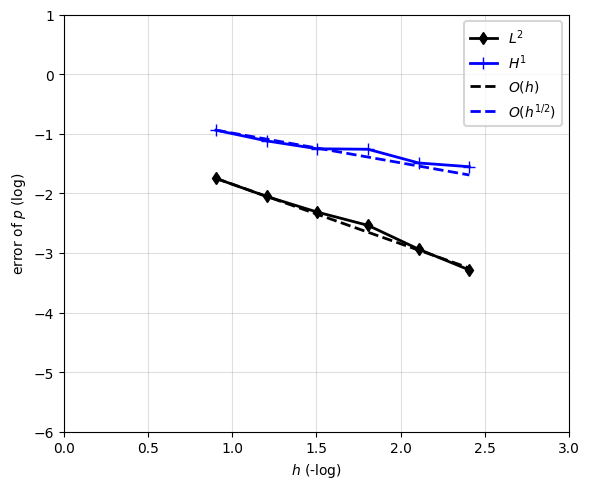

In [5]:
import numpy as np
import matplotlib.pyplot as plt

h = np.array(h_list[-6:], dtype=float)
L2_err = np.array(rL2s_fem_list[-6:], dtype=float)
H1_err = np.array(rH1s_list[-6:], dtype=float)

# Transform axes: x = -log10(h), y = log10(error)
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# L2: black line with diamond markers
ax.plot(x, y_L2, '-d', color='black', label=r"$L^2$", lw=2, ms=6)

# H1: blue line with plus markers
ax.plot(x, y_H1, '-+', color='blue', label=r"$H^1$", lw=2, ms=8)

# Reference line O(h): slope = -1 in (x, y) because y = log10(C) - 1*x
# Anchor it at the first L2 point for visibility
k_ref = 1.0
y0 = y_L2[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='black', lw=2, label=r"$O(h)$")

k_ref = 0.5
y0 = y_H1[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='blue', lw=2, label=r"$O(h^{1/2})$")

# Labels / ticks / grid
ax.set_xlabel(r"$h$ (-log)")
ax.set_ylabel(r"error of $p$ (log)")
ax.grid(True, which="both", alpha=0.4)

# Optional: match the look in your image
ax.set_xlim(0, 3)
ax.set_ylim(-6,1)

# Legend box
leg = ax.legend(frameon=True)
leg.get_frame().set_linewidth(1.5)

plt.tight_layout()
plt.show()


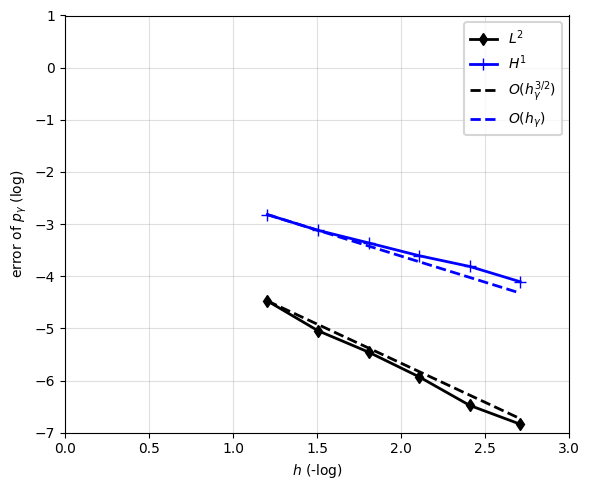

In [6]:
#p_f
import numpy as np
import matplotlib.pyplot as plt

h = np.array(h_list[-6:], dtype=float)
L2_err = np.array(rL2s_fem_list_pf[-6:], dtype=float)
H1_err = np.array(rH1s_list_pf[-6:], dtype=float)

# Transform axes: x = -log10(h), y = log10(error)
x = -np.log10(h/2)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# L2: black line with diamond markers
ax.plot(x, y_L2, '-d', color='black', label=r"$L^2$", lw=2, ms=6)

# H1: blue line with plus markers
ax.plot(x, y_H1, '-+', color='blue', label=r"$H^1$", lw=2, ms=8)

# Reference line O(h): slope = -1 in (x, y) because y = log10(C) - 1*x
# Anchor it at the first L2 point for visibility
k_ref = 1.5
y0 = y_L2[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='black', lw=2, label=r"$O(h_\gamma^{3/2})$")

k_ref = 1.0
y0 = y_H1[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='blue', lw=2, label=r"$O(h_\gamma)$")

# Labels / ticks / grid
ax.set_xlabel(r"$h$ (-log)")
ax.set_ylabel(r"error of $p_\gamma$ (log)")
ax.grid(True, which="both", alpha=0.4)

# Optional: match the look in your image
ax.set_xlim(0, 3)
ax.set_ylim(-7,1)

# Legend box
leg = ax.legend(frameon=True)
leg.get_frame().set_linewidth(1.5)

plt.tight_layout()
plt.show()


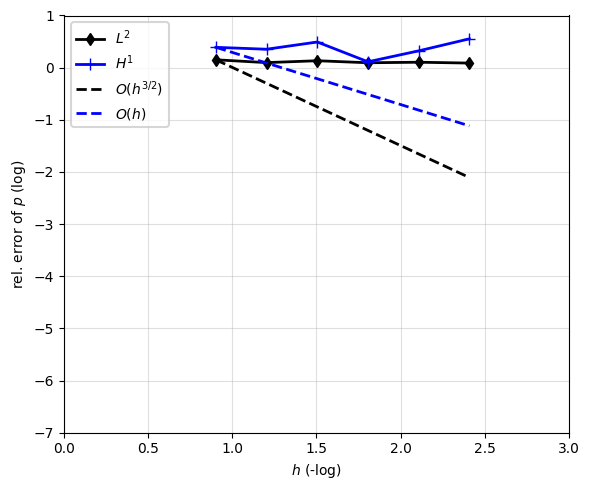

In [7]:
#lmbd
import numpy as np
import matplotlib.pyplot as plt

h = np.array(h_list[-6:], dtype=float)
L2_err = np.array(rL2s_fem_list_lmbd[-6:], dtype=float)
H1_err = np.array(rH1s_list_lmbd[-6:], dtype=float)

# Transform axes: x = -log10(h), y = log10(error)
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# L2: black line with diamond markers
ax.plot(x, y_L2, '-d', color='black', label=r"$L^2$", lw=2, ms=6)

# H1: blue line with plus markers
ax.plot(x, y_H1, '-+', color='blue', label=r"$H^1$", lw=2, ms=8)

# Reference line O(h): slope = -1 in (x, y) because y = log10(C) - 1*x
# Anchor it at the first L2 point for visibility
k_ref = 1.5
y0 = y_L2[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='black', lw=2, label=r"$O(h^{3/2})$")

k_ref = 1.0
y0 = y_H1[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='blue', lw=2, label=r"$O(h)$")

# Labels / ticks / grid
ax.set_xlabel(r"$h$ (-log)")
ax.set_ylabel(r"rel. error of $p$ (log)")
ax.grid(True, which="both", alpha=0.4)

# Optional: match the look in your image
ax.set_xlim(0, 3)
ax.set_ylim(-7,1)

# Legend box
leg = ax.legend(frameon=True)
leg.get_frame().set_linewidth(1.5)

plt.tight_layout()
plt.show()


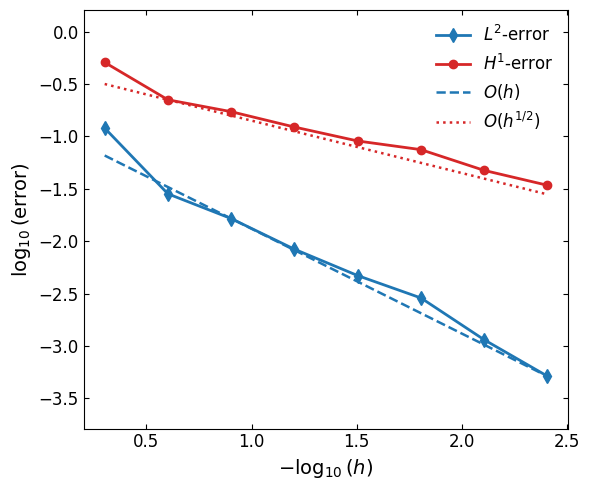

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Data
h = np.array(h_list[-N_ref:], dtype=float)
L2_err = np.array(rL2s_fem_list[-N_ref:], dtype=float)
H1_err = np.array(rH1s_list[-N_ref:], dtype=float)

# Transform axes
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# --- Main curves with color ---
ax.plot(
    x, y_L2, "-d",
    color="tab:blue",
    label=r"$L^2$-error",
    lw=2,
    ms=7,
)

ax.plot(
    x, y_H1, "-o",
    color="tab:red",
    label=r"$H^1$-error",
    lw=2,
    ms=6,
)

# --- Reference lines ---
# O(h): slope = -1
k_ref = 1.0
x0 = x[2]
y0 = y_L2[2]
ax.plot(
    x, y0 - k_ref * (x - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    label=r"$O(h)$"
)

# O(h^{1/2}): slope = -1/2
k_ref = 0.5
x0 = x[1]
y0 = y_H1[1]
ax.plot(
    x, y0 - k_ref * (x - x0),
    ":",
    lw=1.8,
    color="tab:red",
    label=r"$O(h^{1/2})$"
)

# --- Labels & limits ---
ax.set_xlabel(r"$-\log_{10}(h)$", fontsize=14)
ax.set_ylabel(r"$\log_{10}(\text{error})$", fontsize=14)

ax.set_xlim(x.min() - 0.1, x.max() + 0.1)
ax.set_ylim(min(y_L2.min(), y_H1.min()) - 0.5,
            max(y_L2.max(), y_H1.max()) + 0.5)

# No grid
ax.grid(False)

# Ticks
ax.tick_params(direction="in", top=True, right=True, labelsize=12)

# Legend without frame
leg = ax.legend(frameon=False, fontsize=12, loc="best")

plt.tight_layout()
plt.show()


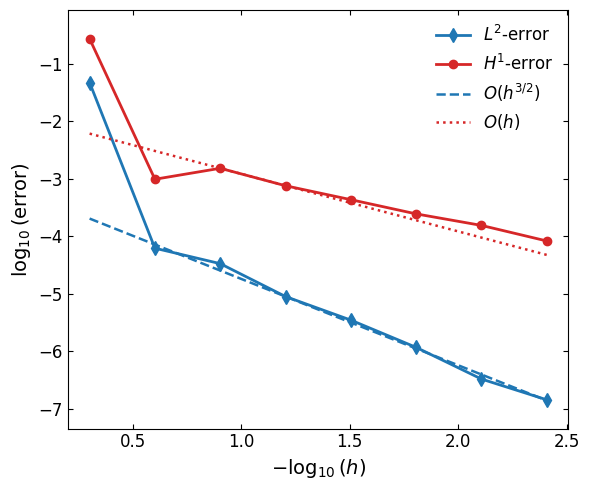

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Data
h = np.array(h_list[-N_ref:], dtype=float)
L2_err = np.array(rL2s_fem_list_pf[-N_ref:], dtype=float)
H1_err = np.array(rH1s_list_pf[-N_ref:], dtype=float)

# Transform axes
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# --- Main curves with color ---
ax.plot(
    x, y_L2, "-d",
    color="tab:blue",
    label=r"$L^2$-error",
    lw=2,
    ms=7,
)

ax.plot(
    x, y_H1, "-o",
    color="tab:red",
    label=r"$H^1$-error",
    lw=2,
    ms=6,
)

# --- Reference lines ---
# O(h): slope = -1
k_ref = 1.5
x0 = x[3]
y0 = y_L2[3]
ax.plot(
    x, y0 - k_ref * (x - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    label=r"$O(h^{3/2})$"
)

# O(h^{1/2}): slope = -1/2
k_ref = 1
x0 = x[2]
y0 = y_H1[2]
ax.plot(
    x, y0 - k_ref * (x - x0),
    ":",
    lw=1.8,
    color="tab:red",
    label=r"$O(h)$"
)

# --- Labels & limits ---
ax.set_xlabel(r"$-\log_{10}(h)$", fontsize=14)
ax.set_ylabel(r"$\log_{10}(\text{error})$", fontsize=14)

ax.set_xlim(x.min() - 0.1, x.max() + 0.1)
ax.set_ylim(min(y_L2.min(), y_H1.min()) - 0.5,
            max(y_L2.max(), y_H1.max()) + 0.5)

# No grid
ax.grid(False)

# Ticks
ax.tick_params(direction="in", top=True, right=True, labelsize=12)

# Legend without frame
leg = ax.legend(frameon=False, fontsize=12, loc="best")

plt.tight_layout()
plt.show()


In [3]:
# jump on Gamma
from dolfinx import geometry
# Given:
# Omega: 3D mesh
# Gamma: 1D mesh
# u: fem.Function on Omega (vector field)
# n_gamma: np.array([nx, ny, nz]) unit vector (same as you already computed)
# Vg: function space on Gamma where you want the jump (same space as lambda, for example)
# n = ufl.FacetNormal(Omega)
# Build vector-valued FE space
# Ve = basix.ufl.element("Lagrange",
#                        Omega.topology.cell_name(),
#                        order,
#                        shape=(3,))
# V_u = fem.functionspace(Omega, Ve)

# u_expr = -k_m * ufl.grad(p_m)                # UFL expression
# expr = fem.Expression(u_expr, V_u.element.interpolation_points)
# u = fem.Function(V_u, name="u")
# u.interpolate(expr) 

u = u_m

dx = x_end - x_start
dy = y_end - y_start

L = np.sqrt(dx**2 + dy**2)   # length of the segment

t = np.array([dx, dy, 0.0]) / L
n_gamma = np.array([-dy, dx, 0.0]) / L  # in-plane normal, z = 0
# m = fem.Constant(Omega, n_gamma)  # m is now the "Gamma-normal" in 3D
m_gamma = fem.Constant(Gamma, n_gamma)

eps = 1e-3  # small offset distance, tuned to your mesh size

# Build a bounding box tree for Omega cells, for point location
bb_tree = geometry.bb_tree(Omega, Omega.topology.dim)

jump_fun = fem.Function(V_l, name="jump_real_on_gamma")

# Coordinates of Gamma dofs
x_g = V_l.tabulate_dof_coordinates().reshape((-1, Gamma.geometry.dim))

# Access to underlying array where we'll store values
jump_vec = jump_fun.x.array
def find_cell(x):
    """
    Find a cell in Omega that contains the point x (3-vector).
    Returns local cell index or None if not found.
    """
    points = np.array([x], dtype=np.float64)          # shape (1, 3)
    candidates = geometry.compute_collisions_points(bb_tree, points)
    cells = geometry.compute_colliding_cells(Omega, candidates, points)
    cell_ids = cells.links(0)                         # cells that contain point 0

    if len(cell_ids) == 0:
        return None
    return int(cell_ids[0])

for i, x_gamma in enumerate(x_g):
    x_gamma = np.asarray(x_gamma, dtype=np.float64)

    x_plus  = x_gamma + eps * n_gamma
    x_minus = x_gamma - eps * n_gamma

    # Find containing cells in Omega
    cell_plus  = find_cell(x_plus)
    cell_minus = find_cell(x_minus)

    if cell_plus is None or cell_minus is None:
        # Near boundary or outside Omega; define jump as 0 or handle specially
        jump_vec[i] = 0.0
        continue

    # Evaluate u at these points
    # u.eval expects x shape (num_points, 3) and cells shape (num_points,)
    x_plus_arr   = np.array([x_plus ], dtype=np.float64)
    x_minus_arr  = np.array([x_minus], dtype=np.float64)
    cells_plus   = np.array([cell_plus ], dtype=np.int32)
    cells_minus  = np.array([cell_minus], dtype=np.int32)

    u_plus_all   = u.eval(x_plus_arr , cells_plus )   # shape (1, 3)
    u_minus_all  = u.eval(x_minus_arr, cells_minus)   # shape (1, 3)

    # Flatten to 1D vectors of length 3
    u_plus_vec   = np.asarray(u_plus_all,  dtype=np.float64).ravel()
    u_minus_vec  = np.asarray(u_minus_all, dtype=np.float64).ravel()
    n_vec        = np.asarray(n_gamma,       dtype=np.float64).ravel()

    # Jump in n_gamma direction
    jump_un = np.dot(u_plus_vec - u_minus_vec, n_vec)
    jump_vec[i] = jump_un

# Push values to PETSc and ghosts (if any)
jump_fun.x.array[:] = jump_vec
jump_fun.x.scatter_forward()


In [5]:
from dolfinx import fem
import ufl

# H(div) flux from the mixed solution
u = u_m

# DG0 space for element-wise residual
# create DG0 space to store results
W = fem.functionspace(Omega, ("DG", 0))
w = ufl.TestFunction(W)

# Average of the DG0 test function on Γ
avg_w = Average(w, restriction_test, Rs)  # Π_R(w) on Γ
# if you want ∫∂K u·n − ∫ Γ λ = 0
# Measures: bulk facets and fracture cells
dS_omega = ufl.Measure("dS", domain=Omega)   # interior facets of omega
# dS_mm = dS_omega(0)
ds_omega = ufl.Measure("ds", domain=Omega)   # boundary facets of omega
ds = ufl.Measure("dx", domain=Gamma)
R_form = (
    ufl.jump(u, n)*ufl.avg(w)*dS_omega
    # + ufl.dot(u, n)*w*ds_omega
    # + lmbd * avg_w * ds
    # + jump_fun * avg_w * ds
)
# R_form = (
#     ufl.dot(ufl.jump(w, n), u) * dS_omega   # interior fluxes
#     + ufl.dot(u, n) * w * ds_omega          # boundary fluxes
#     - lmbd * avg_w * ds                     # fracture coupling term
#     # - q * w * dx if you have sources/sinks
# )
# R_vec = fem.petsc.assemble_vector(fem.form(R_form))
from fenicsx_ii import assemble_vector
R_vec = assemble_vector(R_form)

R = fem.Function(W)
R.x.array[:] = R_vec.array
R.x.scatter_forward()


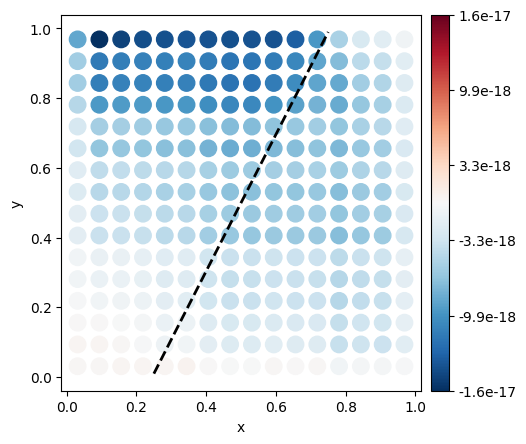

In [7]:
#normal continuity
import matplotlib.pyplot as plt
import numpy as np

# Compute cell centroids
mesh = Omega
tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, 0)
cell_to_vertices = mesh.topology.connectivity(tdim, 0)
x = mesh.geometry.x

centroids = np.array([
    x[cell_to_vertices.links(c)].mean(axis=0)
    for c in range(mesh.topology.index_map(tdim).size_local)
])

# Get local residual values (per cell)
R_local = R.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])
# vmax_abs = 0.001

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

fig, ax = plt.subplots(figsize=(5, 5))

sc = ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c=R_local,
    s=140,
    cmap="RdBu_r",
    vmin=-vmax_abs,
    vmax=vmax_abs
)

ax.plot(
    [x_start, x_end],
    [y_start, y_end],
    color='black',
    linewidth=2,
    linestyle='--'
)

ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")

# --- Colorbar with identical height ---
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig.colorbar(sc, cax=cax)

ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1e}" for t in ticks])

plt.show()


In [6]:
lmbd.x.array

array([-0.37987976,  0.44179926, -1.18156336,  2.40010233, -4.19769761,
        5.79183739, -6.45148936,  5.68889088, -3.9946146 ,  1.77241971,
        0.05940474, -1.68954674,  3.25782658, -4.41336576,  4.80744955,
       -4.16908893,  2.70216963, -1.26599825,  0.10015836,  0.88558253,
       -1.72440411,  2.43867241, -2.59603895,  2.21801398, -1.38845546,
        0.36782309,  0.83694328, -2.30588774,  4.25124973, -5.48122669,
        5.74927521, -4.71572336,  2.98964522, -1.01338029, -0.1139137 ,
        0.79917697, -0.56996793])

In [7]:
jump_fun.x.array

array([-0.06748062, -0.05107948, -0.0258547 , -0.00228445,  0.02159919,
        0.00496072, -0.00548463, -0.01284652, -0.0124183 , -0.01428845,
       -0.01262876, -0.01074554, -0.0056921 , -0.00199725, -0.00171454,
       -0.00156354, -0.00357529, -0.00404664, -0.0059753 , -0.00081739,
        0.00334959,  0.00387439,  0.00286668, -0.00186379,  0.00643816,
        0.01163862,  0.01126256,  0.00284792,  0.00641165,  0.01695573,
        0.01602222,  0.00642616, -0.02703106,  0.00970727,  0.04379613,
        0.07710266,  0.14534651])

In [8]:
# Local conservation
# Discontinuous, piecewise constant space
V0 = fem.functionspace(Omega, ("DG", 0))
v0 = ufl.TestFunction(V0)

# f: source term (e.g. fem.Function or ufl expression)
# local residual R_K = ∫_K (div(q) + f) dx

# residual_form = (ufl.div(u)) * v0 * ufl.dx 
avg_v0 = Average(v0, restriction_test, Rs)  # Π_R(w) on Γ
residual_form_wo_lmbd = (ufl.div(u)) * v0 * ufl.dx #- lmbd * avg_v0 * ds
residual_form = (ufl.div(u)) * v0 * ufl.dx - lmbd * avg_v0 * ds
# L = fem.form(residual_form)

# from dolfinx.fem.petsc import assemble_vector

# R_vec = assemble_vector(L)  # PETSc vector, length = number of cells
from fenicsx_ii import assemble_vector
R_vec = assemble_vector(residual_form)  # PETSc vector, length = number of cells
R_vec_wo_lmbd = assemble_vector(residual_form_wo_lmbd)  # PETSc vector, length = number of cells
# R_vec.ghostUpdate(addv=fem.petsc.InsertMode.ADD, mode=fem.petsc.ScatterMode.REVERSE)

R = fem.Function(V0)
R.x.array[:] = R_vec.array    # copy values into DG0 function

R_wo_lmbd = fem.Function(V0)
R_wo_lmbd.x.array[:] = R_vec_wo_lmbd.array    # copy values into DG0 function

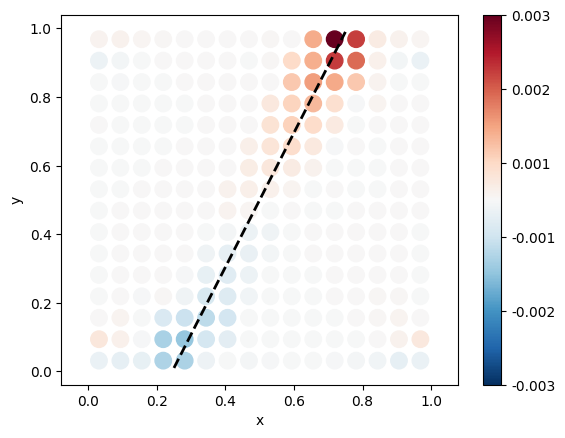

In [10]:
# Get local residual values (per cell)
R_local = R_wo_lmbd.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])

plt.figure()
sc = plt.scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=140, cmap="RdBu_r", vmin=-vmax_abs, vmax=vmax_abs)
plt.plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
# plt.colorbar(sc)
cbar = plt.colorbar(sc)

# 6 ticks between vmin and vmax, including both ends
ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.3f}" for t in ticks])

plt.axis("equal")
plt.xlabel("x"); plt.ylabel("y")
# plt.title("Local flux balance per element (DG0)")
plt.show()

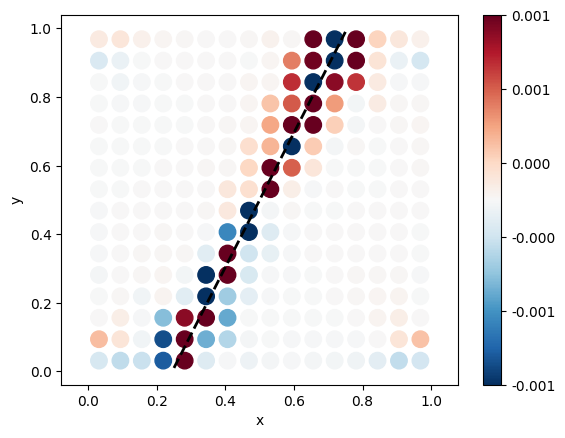

In [14]:
# Get local residual values (per cell)
R_local = R.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])
vmax_abs = 0.001

plt.figure()
sc = plt.scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=140, cmap="RdBu_r", vmin=-vmax_abs, vmax=vmax_abs)
plt.plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
# plt.colorbar(sc)
cbar = plt.colorbar(sc)

# 6 ticks between vmin and vmax, including both ends
ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.3f}" for t in ticks])

plt.axis("equal")
plt.xlabel("x"); plt.ylabel("y")
# plt.title("Local flux balance per element (DG0)")
plt.show()

In [23]:
#looping manually
import numpy as np
from dolfinx import mesh, geometry

tdim_O = Omega.topology.dim          # 3
tdim_G = Gamma.topology.dim          # 1
gdim   = Omega.geometry.dim          # should be 3 as well

# Local number of cells on Gamma
cell_map_G = Gamma.topology.index_map(tdim_G)
num_cells_G = cell_map_G.size_local

# Connectivity: Γ-cells -> vertices
Gamma.topology.create_connectivity(tdim_G, 0)
c2v_G = Gamma.topology.connectivity(tdim_G, 0)

# Build a point (midpoint) for each Γ-cell in physical coordinates
points = np.zeros((gdim, num_cells_G), dtype=np.float64)

for g in range(num_cells_G):
    vs = c2v_G.links(g)             # vertices of Gamma cell g
    x_g = Gamma.geometry.x[vs]      # shape (num_vertices, gdim)
    midpoint = x_g.mean(axis=0)     # average of vertices
    points[:, g] = midpoint

# Build bounding-box tree for Ω
bbt = geometry.bb_tree(Omega, tdim_O)

# Find candidate cells in Ω that might contain each point
cell_candidates = geometry.compute_collisions_points(bbt, points.T)

# Filter candidates to the actual colliding cells
cells = geometry.compute_colliding_cells(Omega, cell_candidates, points.T)
# cells is length num_cells_G: cells[g] = Ω-cell id that contains midpoint of Γ-cell g,
# or -1 if not found.

gamma_to_omega = np.array(
    [cells.links(g)[0] if len(cells.links(g)) > 0 else -1
     for g in range(num_cells_G)],
    dtype=np.int32
)

In [25]:
tdim_G = Gamma.topology.dim
cell_indices_G = np.arange(num_cells_G, dtype=np.int32)

gamma_tags = mesh.meshtags(
    Gamma,
    tdim_G,
    cell_indices_G,    # entities on Gamma
    gamma_to_omega     # values = Ω-cell id (cid)
)

dx_Gc = ufl.Measure("dx", domain=Gamma, subdomain_data=gamma_tags)

from dolfinx import fem
import ufl

u = u_m             # on Omega
# lmbd = lambda_on_G  # on Gamma

# Bulk cell tagging
tdim_O = Omega.topology.dim
cell_map_O = Omega.topology.index_map(tdim_O)
num_cells_O = cell_map_O.size_local

bulk_cells = np.arange(num_cells_O, dtype=np.int32)
bulk_tags = mesh.meshtags(
    Omega,
    tdim_O,
    bulk_cells,   # entities
    bulk_cells    # values = Ω-cell id
)

dx_Oc = ufl.Measure("dx", domain=Omega, subdomain_data=bulk_tags)
div_u = ufl.div(u)

R_cell = np.zeros(num_cells_O, dtype=np.float64)

for cid in bulk_cells:
    # ∫_K div(u) dx  (net flux out of Ω-cell cid)
    flux = fem.assemble_scalar(fem.form(div_u * dx_Oc(cid)))

    # ∫_{Γ∩K} λ ds   (fracture term in that cell)
    frac = fem.assemble_scalar(fem.form(lmbd * dx_Gc(cid)))

    R_cell[cid] = flux - frac


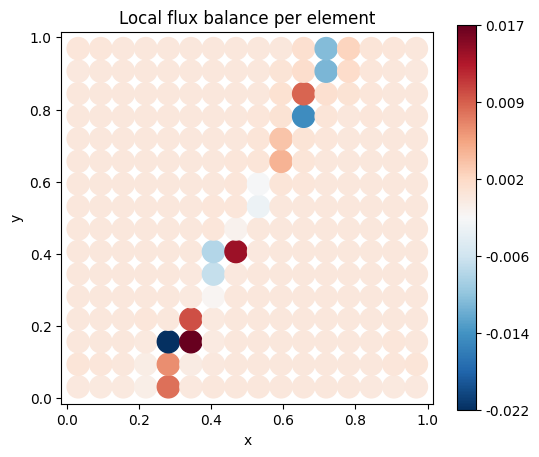

In [29]:
mesh = Omega
tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, 0)
cell_to_vertices = mesh.topology.connectivity(tdim, 0)
x = mesh.geometry.x

num_cells = mesh.topology.index_map(tdim).size_local

centroids = np.array([
    x[cell_to_vertices.links(c)].mean(axis=0)
    for c in range(num_cells)
])

R_local = R_cell  # one value per local cell
vmin = np.min(R_local)
vmax = np.max(R_local)
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 5))

dx_points = ax.transData.transform((1, 0))[0] - ax.transData.transform((0, 0))[0]
dy_points = ax.transData.transform((0, 1))[1] - ax.transData.transform((0, 0))[1]

# h should be a characteristic cell size; if you don't have it, you can set e.g. h = 1.0
# or compute an average cell diameter. For now assume you already have h.
r_points = h/2 * 0.6 * (dx_points + dy_points)   # roughly scale marker radius

s_val = r_points**2  # marker size in points^2

sc = ax.scatter(
    centroids[:, 0],  # x
    centroids[:, 1],  # y
    c=R_local,
    s=s_val,
    cmap="RdBu_r"
)

cbar = plt.colorbar(sc)

# 6 ticks between vmin and vmax, including both ends
ticks = np.linspace(vmin, vmax, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.3f}" for t in ticks])

ax.set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Local flux balance per element")
plt.show()


In [24]:
# Safety check
if np.any(gamma_to_omega < 0):
    print("Warning: Γ-cells not found in Ω:", np.where(gamma_to_omega < 0)[0])

In [26]:
num_cells_O

256